<a href="https://colab.research.google.com/github/dimaetoeto/ItmoML/blob/main/ITMO_ML_Task1_Shmyrov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В рамках моей диссертации я хочу попробовать аугментацию аудио данных для сонификации на основе какого нибудь популярного датасета. Я выбрал ***датасет urbansound8k***, тк часто наблюдал его в статьях, он достаточно прост в установке и имеет не слишком большой объем, таким образом отлично подходит для учебных целей для человека, практически не знакомого с программированием.

**Сонификация –** это процесс преобразования данных в звук, а аугментация аудио данных направлена на улучшение их качества и информативности. Исходя из этого, метрика должна оценивать, насколько эффективно аугментация улучшает восприятие и интерпретацию аудио данных.

**Выбор и обоснование метрики для измерения качества:**
Для начала рассмотрим задачу классификации звуков на основе датасета UrbanSound8K. Этот датасет содержит множество классов звуковых событий, что делает его подходящим для задач многоклассовой классификации.

**Предлагаемая метрика:** Для оценки качества модели предлагается использовать метрику Accuracy (точность), а также F1-Score для более детальной оценки качества в условиях возможного дисбаланса классов.

**Обоснование:** Accuracy является интуитивно понятной и широко используемой метрикой для задач классификации, позволяющей быстро оценить общую способность модели правильно классифицировать аудиофайлы. F1-Score более чувствителен к дисбалансу классов и объединяет в себе метрики Precision и Recall, что делает его полезным для более глубокой оценки качества модели.

In [1]:
!pip install pandas
!pip install librosa
!pip install plotly
!pip install matplotlib
!pip install mutagen
!pip install pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 4.2 MB/s eta 0:00:00


In [ ]:
import os
import time
import librosa
import zipfile
import mutagen
import mutagen.wave
import numpy as np
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

Скачаем датасет

In [ ]:
#Скачивание датасета UrbanSound8K и его распаковка
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2024-02-04 14:37:10--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2024-02-04 14:37:11--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  13.9MB/s    in 7m 12s  

2024-02-04 14:44:24 (13.3 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



Просмотрим файл readme для будущей работы с этим датасетом.

In [ ]:
# Вывод содержимого файла README датасета для ознакомления
!cat UrbanSound8K/UrbanSound8K_README.txt

UrbanSound8K

Created By
----------

Justin Salamon*^, Christopher Jacoby* and Juan Pablo Bello*
* Music and Audio Research Lab (MARL), New York University, USA
^ Center for Urban Science and Progress (CUSP), New York University, USA
http://serv.cusp.nyu.edu/projects/urbansounddataset
http://marl.smusic.nyu.edu/
http://cusp.nyu.edu/

Version 1.0


Description
-----------

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, 
children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. The classes are 
drawn from the urban sound taxonomy described in the following article, which also includes a detailed description of 
the dataset and how it was compiled:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

All excerpts are taken from field recordings uploaded to www.freesou

**EDA Анализ данных:**


---


Для EDA необходимо изучить базовые характеристики датасета, включая распределение классов, длительность аудиофайлов, возможные выбросы и качество записей. Также важно визуализировать данные, например, в виде волновых форм или спектрограмм для различных классов звуков.

In [ ]:
# Функция для создания DataFrame из CSV файла датасета с путями к аудиофайлам
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [ ]:
# Создание DataFrame и вывод первых строк для предварительного просмотра
dataset_df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')
dataset_df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class                                     filepath  
0          dog_bark    UrbanSound8K/audio/fold5/100032-3-0-0.wav  
1  children_playing  UrbanSound8K/audio/fold5/100263-2-0-117.wav  
2  children_playing  UrbanSound8K/audio/fold5/100263-2-0-121.wav  
3  children_playing  UrbanSound8K/audio/fold5/100263-2-0-126.wav  
4  children_playing  UrbanSound8K/audio/fold5/100263-2-0-137.wav

In [ ]:
# Группировка и подсчет количества файлов по классам звуков
dataset_df.groupby('class').slice_file_name.count()

class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: slice_file_name, dtype: int64

In [ ]:
# Вывод названий столбцов и типов данных в DataFrame
dataset_df.columns

Index(['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold',
       'classID', 'class', 'filepath'],
      dtype='object')

In [ ]:
dataset_df.dtypes

slice_file_name     object
fsID                 int64
start              float64
end                float64
salience             int64
fold                 int64
classID              int64
class               object
filepath            object
dtype: object

Мы рассмотрели, из каких столбцов состоит таблица, какими файлами он представлен и какие типы звуков представляет. Теперь воспользуемся возможностями библиотеки mutagen чтобы описать характеристики звуков внутри файлов .wav

In [ ]:
# Функция для получения метаданных аудиофайла с помощью библиотеки mutagen
def get_audio_metadata_mutagen(filepath):
    metadata = {}
    f = mutagen.wave.WAVE(filepath)
    metadata['length'] = f.info.length
    metadata['bitrate'] = f.info.bitrate
    metadata['channels'] = f.info.channels
    metadata['sample_rate'] = f.info.sample_rate
    metadata['bits_per_sample'] = f.info.bits_per_sample
    return metadata

# Функция для вычисления статистики аудио и добавления новых столбцов в DataFrame
def compute_audio_statistics(dataset_df):
    metadata_dict = {'length': [], 'bitrate': [], 'channels': [], 'sample_rate': [], 'bits_per_sample': []}
    # 'экстрагируем метаданные'
    for filepath in dataset_df['filepath']:
        metadata = get_audio_metadata_mutagen(filepath)
        for key in metadata_dict.keys():
            metadata_dict[key].append(metadata[key])
    # добавим новые столбцы в фрейм
    for key in metadata_dict.keys():
        dataset_df[key] = metadata_dict[key]

    return dataset_df

In [ ]:
# Удаление ненужных столбцов и добавление статистики аудио в DataFrame
dataset_df = dataset_df.drop(columns=['fold', 'slice_file_name', 'fsID', 'start', 'end'])

In [ ]:
audio_statistics_df = compute_audio_statistics(dataset_df)

In [ ]:
# Вывод статистического описания аудио данных
audio_statistics_df.describe()

salience      classID       length       bitrate     channels  \
count  8732.000000  8732.000000  8732.000000  8.732000e+03  8732.000000   
mean      1.347000     4.592877     3.603644  1.800775e+06     1.915369   
std       0.476043     2.894544     0.980913  9.765852e+05     0.278348   
min       1.000000     0.000000     0.000816  4.409600e+04     1.000000   
25%       1.000000     2.000000     4.000000  1.411200e+06     2.000000   
50%       1.000000     4.000000     4.000000  1.411200e+06     2.000000   
75%       2.000000     7.000000     4.000000  2.116800e+06     2.000000   
max       2.000000     9.000000     4.000000  1.228800e+07     2.000000   

         sample_rate  bits_per_sample  
count    8732.000000      8732.000000  
mean    48456.979272        18.780119  
std     15300.080707         4.227168  
min      8000.000000         4.000000  
25%     44100.000000        16.000000  
50%     44100.000000        16.000000  
75%     48000.000000        24.000000  
max    192000.000000        32.000000

Итак, мы видим, что  используется Частота дискретизации от 8 кГц до 192 кГц (в основном 44 кГц, 48 кГц).
Длительность аудио варьируется от 0.0008 секунд до 4 секунд (в основном 4 секунды).
Используемые биты на образец варьируются от 4 до 32 (в основном 24 бита).
Данные необходимо будет стандартизировать в дальнейшем перед подачей в модель машинного обучения.

In [ ]:
# Подсчет количества аудиофайлов с различной частотой дискретизации и битностью
audio_statistics_df['sample_rate'].value_counts(), audio_statistics_df['bits_per_sample'].value_counts()

(44100     5370
 48000     2502
 96000      610
 24000       82
 16000       45
 22050       44
 11025       39
 192000      17
 8000        12
 11024        7
 32000        4
 Name: sample_rate, dtype: int64,
 16    5758
 24    2753
 32     169
 8       43
 4        9
 Name: bits_per_sample, dtype: int64)

Из этого следует, что совсем мало аудиофайлов с частотой дискретизации ниже чем 44100 и битностью ниже 16. Вероятно, эти файлы имеет смысл удалить из модели в будущем.  Рассмотрим подробнее, к каким классам они принадлежат

In [ ]:
# Группировка данных по классам и их описание
audio_statistics_df.groupby('class').describe()


salience                                               \
                    count      mean       std  min  25%  50%  75%  max   
class                                                                    
air_conditioner    1000.0  1.431000  0.495464  1.0  1.0  1.0  2.0  2.0   
car_horn            429.0  1.643357  0.479567  1.0  1.0  2.0  2.0  2.0   
children_playing   1000.0  1.412000  0.492441  1.0  1.0  1.0  2.0  2.0   
dog_bark           1000.0  1.355000  0.478753  1.0  1.0  1.0  2.0  2.0   
drilling           1000.0  1.098000  0.297463  1.0  1.0  1.0  1.0  2.0   
engine_idling      1000.0  1.084000  0.277527  1.0  1.0  1.0  1.0  2.0   
gun_shot            374.0  1.187166  0.390567  1.0  1.0  1.0  1.0  2.0   
jackhammer         1000.0  1.269000  0.443662  1.0  1.0  1.0  2.0  2.0   
siren               929.0  1.710441  0.453802  1.0  1.0  2.0  2.0  2.0   
street_music       1000.0  1.375000  0.484365  1.0  1.0  1.0  2.0  2.0   

                 classID       ... sample_rate           bits_per_sample  \
                   count mean  ...         75%       max           count   
class                          ...                                         
air_conditioner   1000.0  0.0  ...     48000.0   48000.0          1000.0   
car_horn           429.0  1.0  ...     48000.0   96000.0           429.0   
children_playing  1000.0  2.0  ...     48000.0   96000.0          1000.0   
dog_bark          1000.0  3.0  ...     48000.0   96000.0          1000.0   
drilling          1000.0  4.0  ...     44100.0  192000.0          1000.0   
engine_idling     1000.0  5.0  ...     48000.0   96000.0          1000.0   
gun_shot           374.0  6.0  ...     48000.0   96000.0           374.0   
jackhammer        1000.0  7.0  ...     48000.0   96000.0          1000.0   
siren              929.0  8.0  ...     48000.0   48000.0           929.0   
street_music      1000.0  9.0  ...     44100.0   96000.0          1000.0   

                                                                     
                       mean       std   min   25%   50%   75%   max  
class                                                                
air_conditioner   19.584000  4.393432  16.0  16.0  16.0  24.0  32.0  
car_horn          17.641026  3.280044  16.0  16.0  16.0  16.0  32.0  
children_playing  18.964000  4.077171   4.0  16.0  16.0  24.0  24.0  
dog_bark          18.288000  3.939108  16.0  16.0  16.0  24.0  32.0  
drilling          18.180000  4.235273   4.0  16.0  16.0  24.0  32.0  
engine_idling     19.688000  4.459882  16.0  16.0  16.0  24.0  32.0  
gun_shot          18.331551  3.640290  16.0  16.0  16.0  24.0  24.0  
jackhammer        20.044000  5.047727   4.0  16.0  16.0  24.0  32.0  
siren             17.550054  3.630558   8.0  16.0  16.0  16.0  32.0  
street_music      18.512000  3.714789  16.0  16.0  16.0  24.0  24.0  

[10 rows x 56 columns]

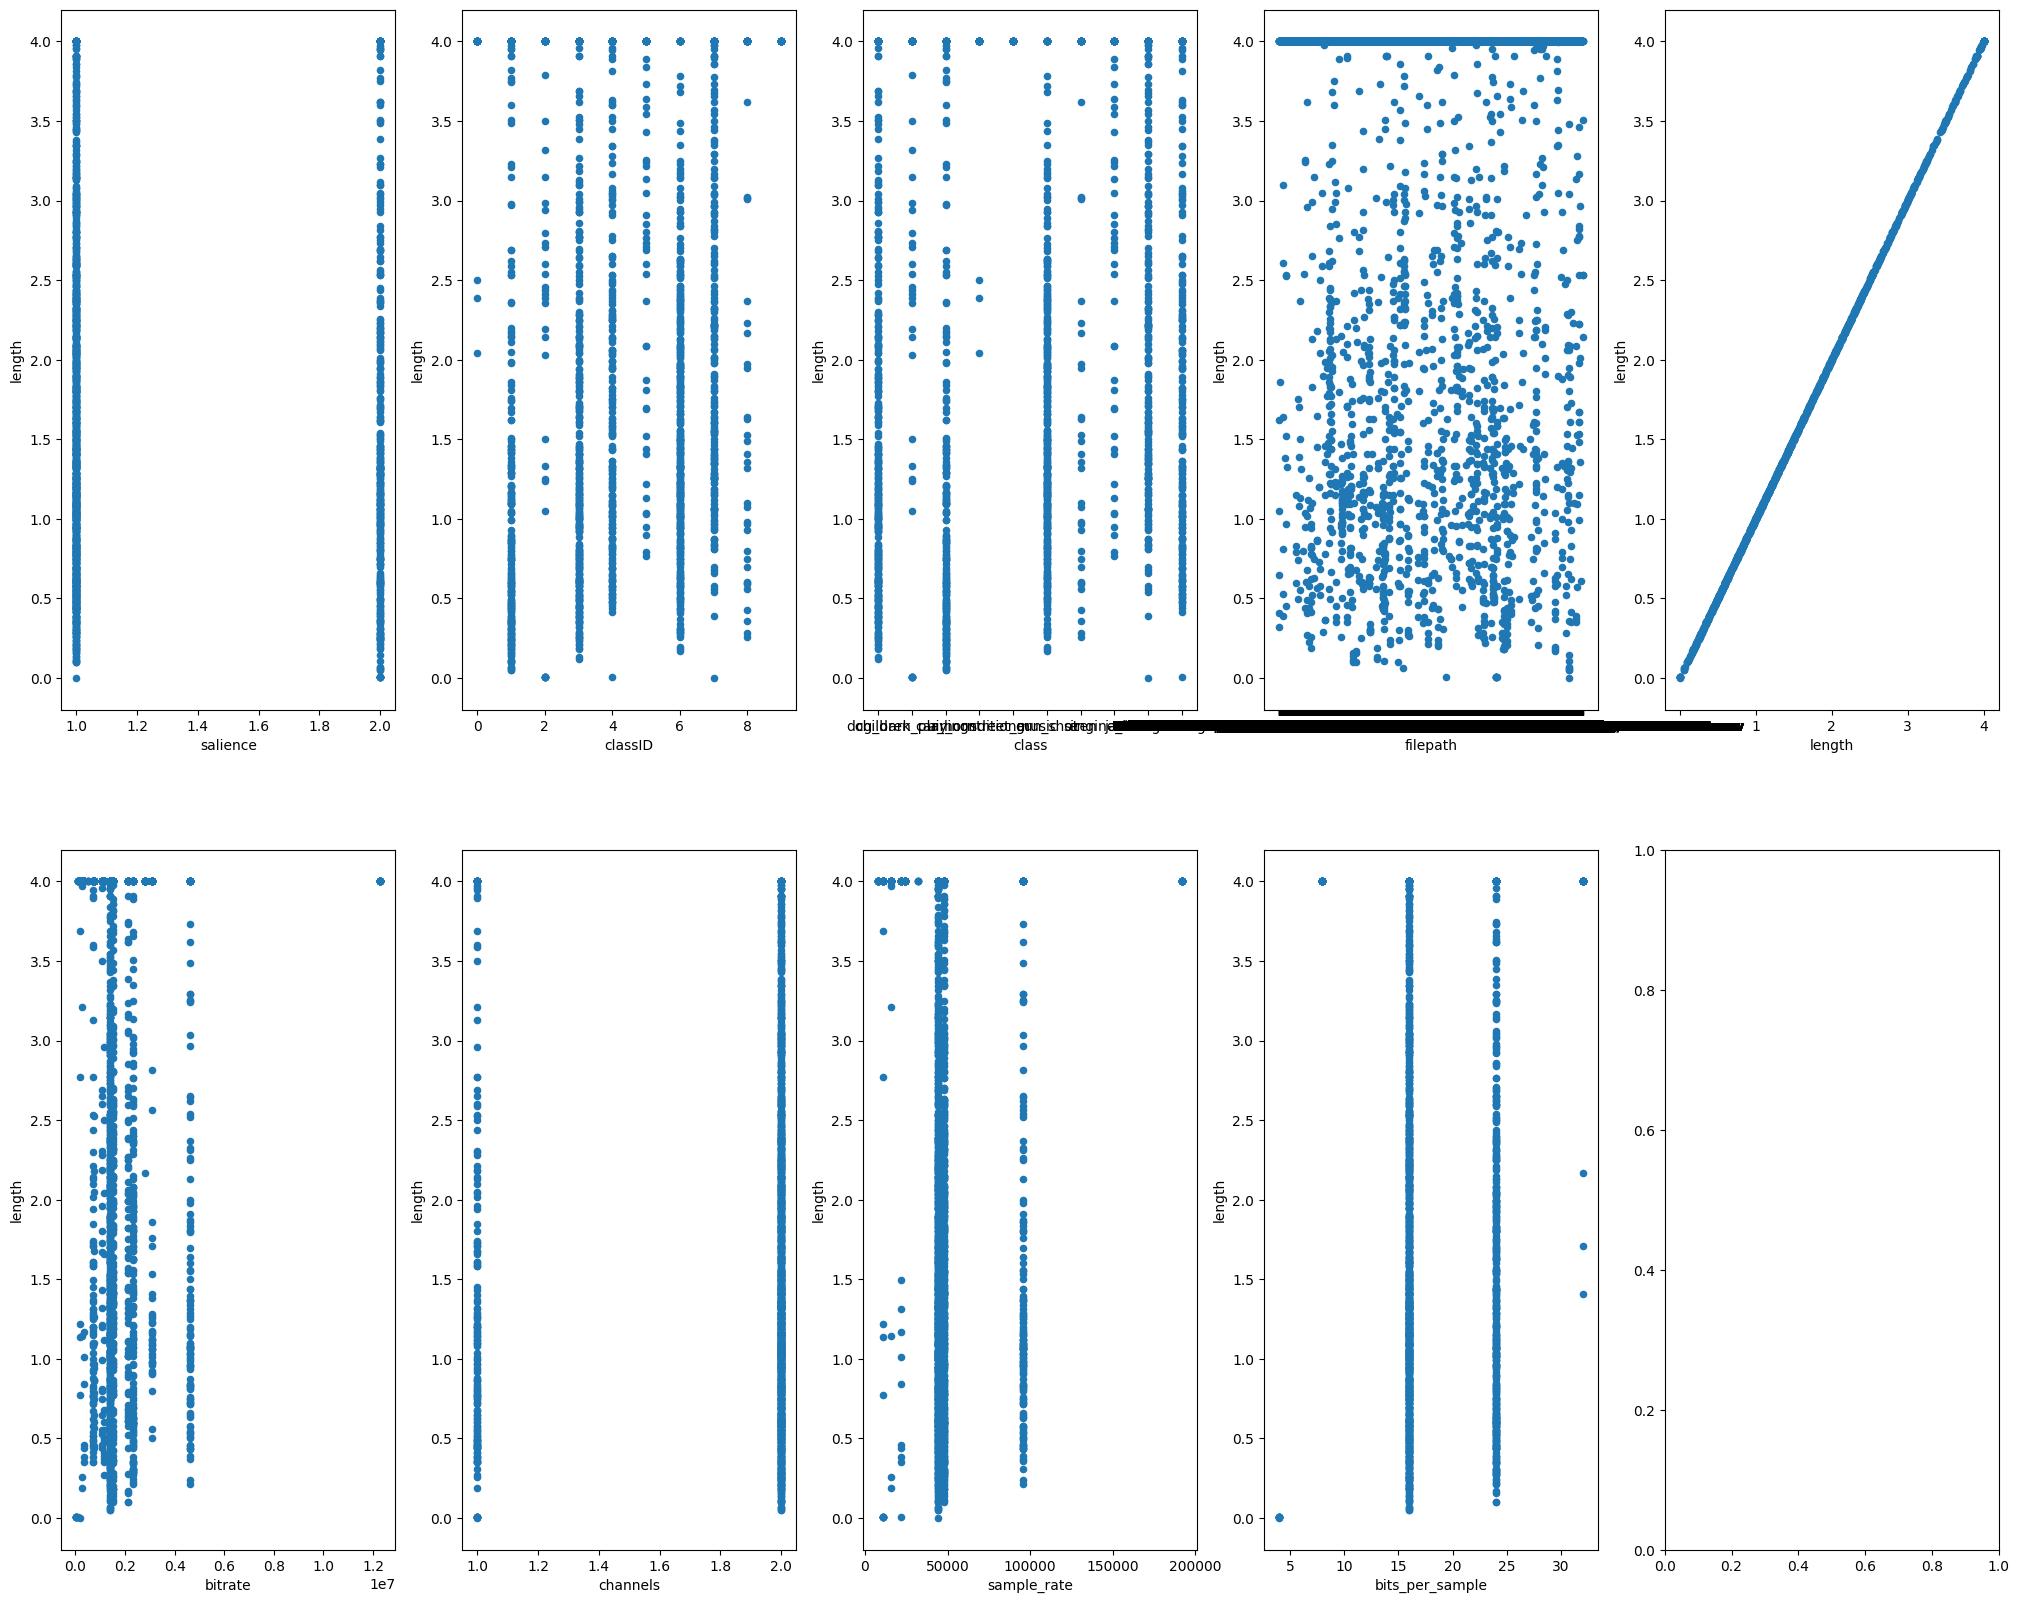

In [ ]:
# Визуализация зависимости длины аудио от различных параметров
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 20))
for idx, feature in enumerate(audio_statistics_df.columns):
    audio_statistics_df.plot(feature, "length", subplots=True, kind="scatter", ax=axes[idx // 5, idx % 5])


<ipython-input-16-653dc35bd520>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(audio_statistics_df['length'], bins=50, color='r', ax=axes[0, 0])
<ipython-input-16-653dc35bd520>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(audio_statistics_df['bitrate'], bins=50, color='g', ax=axes[0, 1])
<

<Axes: xlabel='salience', ylabel='Density'>

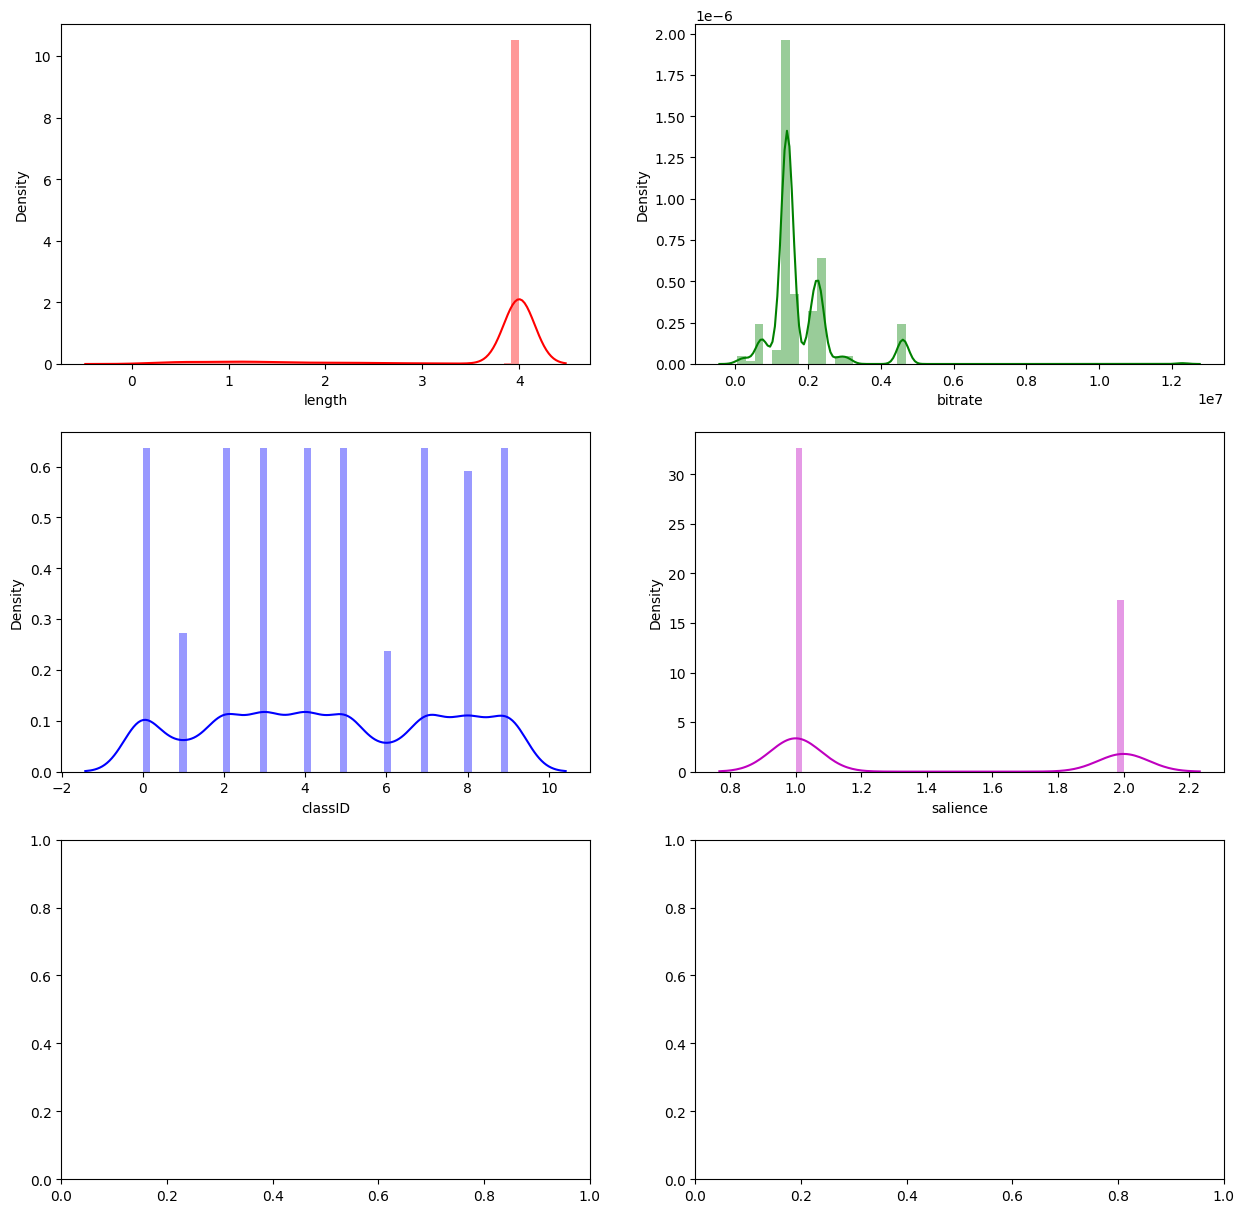

In [ ]:
# Визуализация распределения различных параметров аудио
import seaborn as sns
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
sns.distplot(audio_statistics_df['length'], bins=50, color='r', ax=axes[0, 0])
sns.distplot(audio_statistics_df['bitrate'], bins=50, color='g', ax=axes[0, 1])
sns.distplot(audio_statistics_df['classID'], bins=50, color='b', ax=axes[1, 0])
sns.distplot(audio_statistics_df['salience'].dropna(), bins=50, color='m', ax=axes[1, 1])

Мы посмотрели, как класс зависит от различных параметров и составили графики для других параметров.


Для лучшего наблюдения за работой модели и ошибками между различными классами построим матрицу. Яркость цвета на карте будет отражать частоту встречаемости пар классов в датасете. Это поможет увидеть, какие классы чаще всего встречаются вместе.







In [ ]:
# Создание матрицы для наблюдения за встречаемостью пар классов в датасете
class_dictionary = {3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}
classes = [class_dictionary[key] for key in sorted(class_dictionary.keys())]

In [ ]:

pivot_table = pd.crosstab(index=audio_statistics_df['class'], columns=audio_statistics_df['class'])


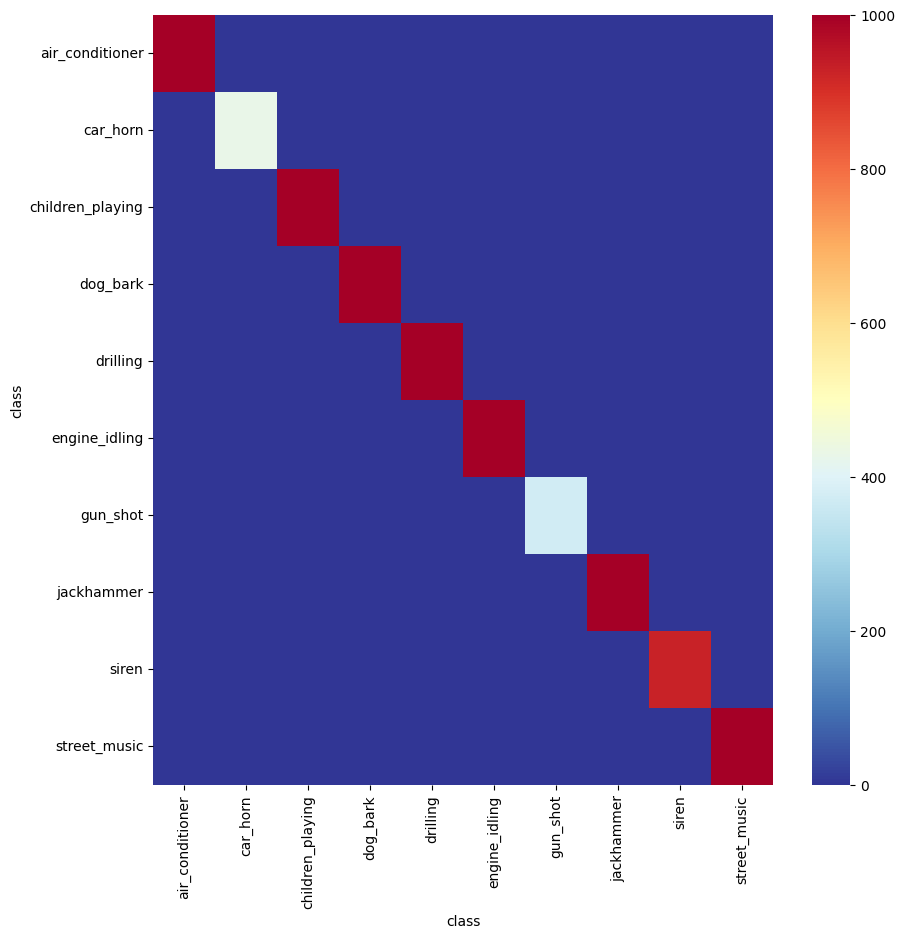

In [ ]:
# Визуализация матрицы с помощью тепловой карты
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(pivot_table, cmap="RdYlBu_r")
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Закодируем категориальные данные
label_encoder = LabelEncoder()
audio_statistics_df['class_encoded'] = label_encoder.fit_transform(audio_statistics_df['class'])

# Выборка числовых колонок для масштабирования
num_cols = audio_statistics_df.select_dtypes(include=['float64', 'int64'])

# Масштабирование
scaler = StandardScaler()
df_scaled = scaler.fit_transform(num_cols)
print(df_scaled[:5])


[[-0.72896673 -0.5503347  -3.35022674 -0.39893885  0.30406562 -0.28478469
  -0.65771647 -0.5503347 ]
 [-0.72896673 -0.89583205  0.40409157 -0.39893885  0.30406562 -0.28478469
  -0.65771647 -0.89583205]
 [-0.72896673 -0.89583205  0.40409157 -0.39893885  0.30406562 -0.28478469
  -0.65771647 -0.89583205]
 [-0.72896673 -0.89583205  0.40409157 -0.39893885  0.30406562 -0.28478469
  -0.65771647 -0.89583205]
 [-0.72896673 -0.89583205  0.40409157 -0.39893885  0.30406562 -0.28478469
  -0.65771647 -0.89583205]]


In [ ]:
df_scaled.shape

(8732, 8)

In [ ]:
# Применение метода главных компонент (PCA) для уменьшения размерности данных
from sklearn.decomposition import PCA
model = PCA(n_components=3)
model.fit(df_scaled)
df_pca_3 = model.transform(df_scaled)

In [ ]:
# Функция для отрисовки 3D графика
def draw_3d(data):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')

    for f in data:
        ax.scatter(f[0], f[1], f[2], c='b')
    plt.show()

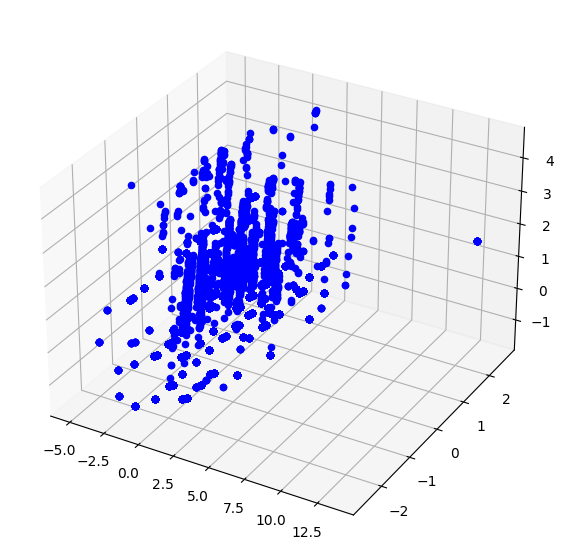

In [ ]:
draw_3d(df_pca_3)

Мы построили трехмерный график, отобразим его двухмерно. Пока график не очень информативный

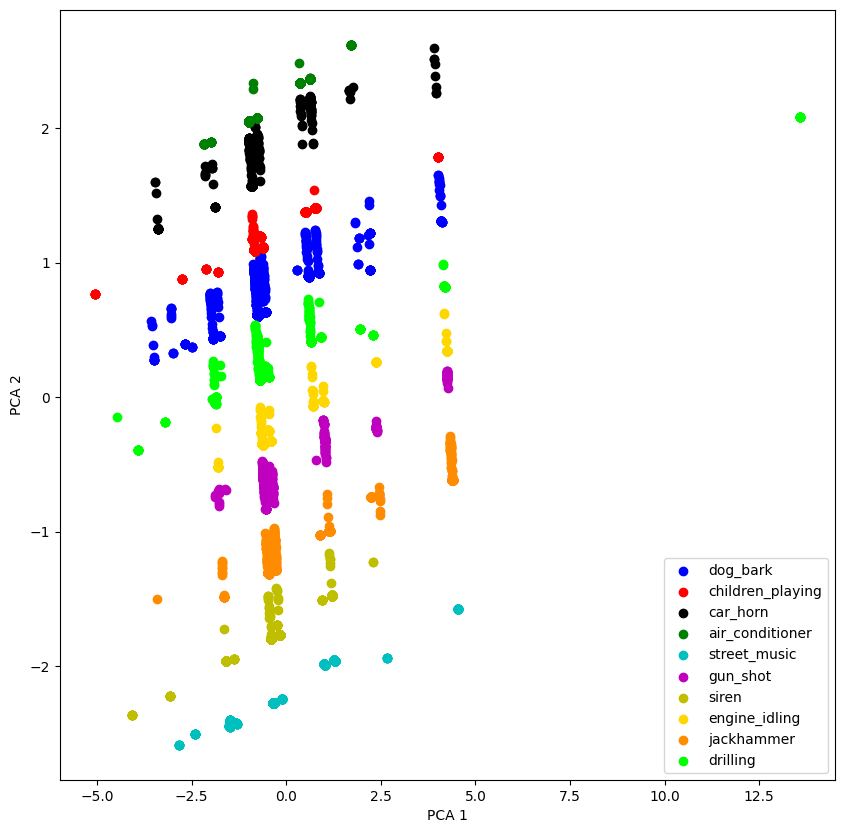

In [ ]:
# Преобразование данных с помощью PCA на 2 компоненты и визуализация
model = PCA(n_components=2)
model.fit(df_scaled)
pca_coords = model.transform(df_scaled)

df_to_draw = pd.DataFrame({
    'class': audio_statistics_df['class'],  # Указываем столбец 'class' из исходного DataFrame
    'pca1': pca_coords[:, 0],
    'pca2': pca_coords[:, 1],
})

colors = ['b', 'r', 'k', 'g', 'c', 'm', 'y', 'gold', 'darkorange', 'lime']

# Теперь можно построить график
plt.figure(figsize=(10, 10))
for i, c in enumerate(df_to_draw['class'].unique()):
    class_data = df_to_draw[df_to_draw['class'] == c]
    plt.scatter(class_data['pca1'], class_data['pca2'], color=colors[i], label=c)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()


Обнаружен один явно вылетающий звук из класса drilling, в дальнейшем нужно будет рассмотреть эту аномалию подробнее и вероятно исключить её.

In [ ]:
# Применение PCA на 3 компоненты и вывод первых пяти строк
model = PCA(n_components=3)
model.fit(df_scaled)
pca_coords = model.transform(df_scaled)
pca_coords[:5]

array([[-0.84780954,  0.94947134,  2.19764087],
       [-0.847674  ,  1.09219501, -0.02160415],
       [-0.847674  ,  1.09219501, -0.02160415],
       [-0.847674  ,  1.09219501, -0.02160415],
       [-0.847674  ,  1.09219501, -0.02160415]])

In [ ]:
# Визуализация данных в 3D с использованием PCA
df_to_draw = pd.DataFrame({
    'class': audio_statistics_df['class'],
    'pca1': pca_coords[:, 0],
    'pca2': pca_coords[:, 1],
    'pca3': pca_coords[:, 2],
})
colors = ['b', 'r', 'k', 'g', 'c', 'm', 'y', 'gold', 'darkorange', 'lime']

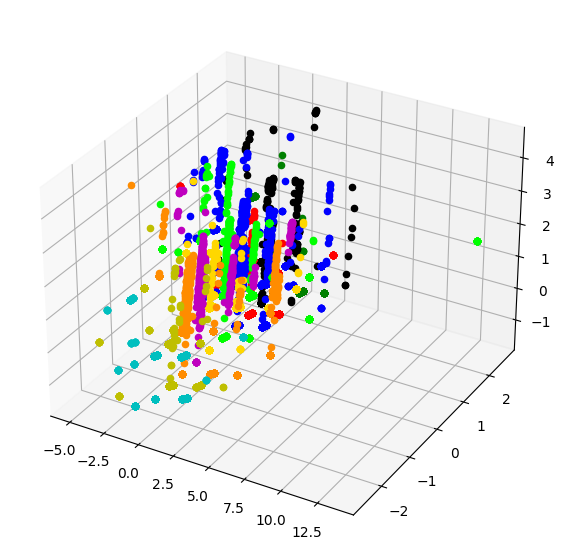

In [ ]:

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

unique_classes = df_to_draw['class'].unique()
class_to_color = {cl: colors[i] for i, cl in enumerate(unique_classes)}
for _, row in df_to_draw.iterrows():
   ax.scatter(row['pca1'], row['pca2'], row['pca3'], c=class_to_color[row['class']])

plt.show()

**Визуализация аудио файлов **

---


Важно глубже изучить аудиофайлы, чтобы выявить ключевые характеристики и потенциальные проблемы, которые могут влиять на процесс обучения модели. В этом фрагменте кода мы загружаем аудиофайлы и визуализируем их волновые формы, выбирая по одному файлу из каждого класса. Это позволяет оценить общие характеристики аудиосигналов визуально.

In [ ]:

import librosa
import matplotlib.pyplot as plt

# выбираем какой нибудь сэмпл в каждом классе
random_samples = dataset_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# визуализируем аудиоволны
fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        times = np.arange(len(audio_file)) / float(sample_rate)
        axs[row][col].plot(times, audio_file)
        axs[row][col].set_title('{}'.format(labels[index]))
        axs[row][col].set_xlabel('Time (s)')
        axs[row][col].set_ylabel('Amplitude')
        index += 1
fig.tight_layout()

Здесь мы применяем STFT к выбранным аудиофайлам, чтобы преобразовать аудиосигналы в частотное представление. Визуализация STFT позволяет увидеть частотные компоненты сигнала во времени.

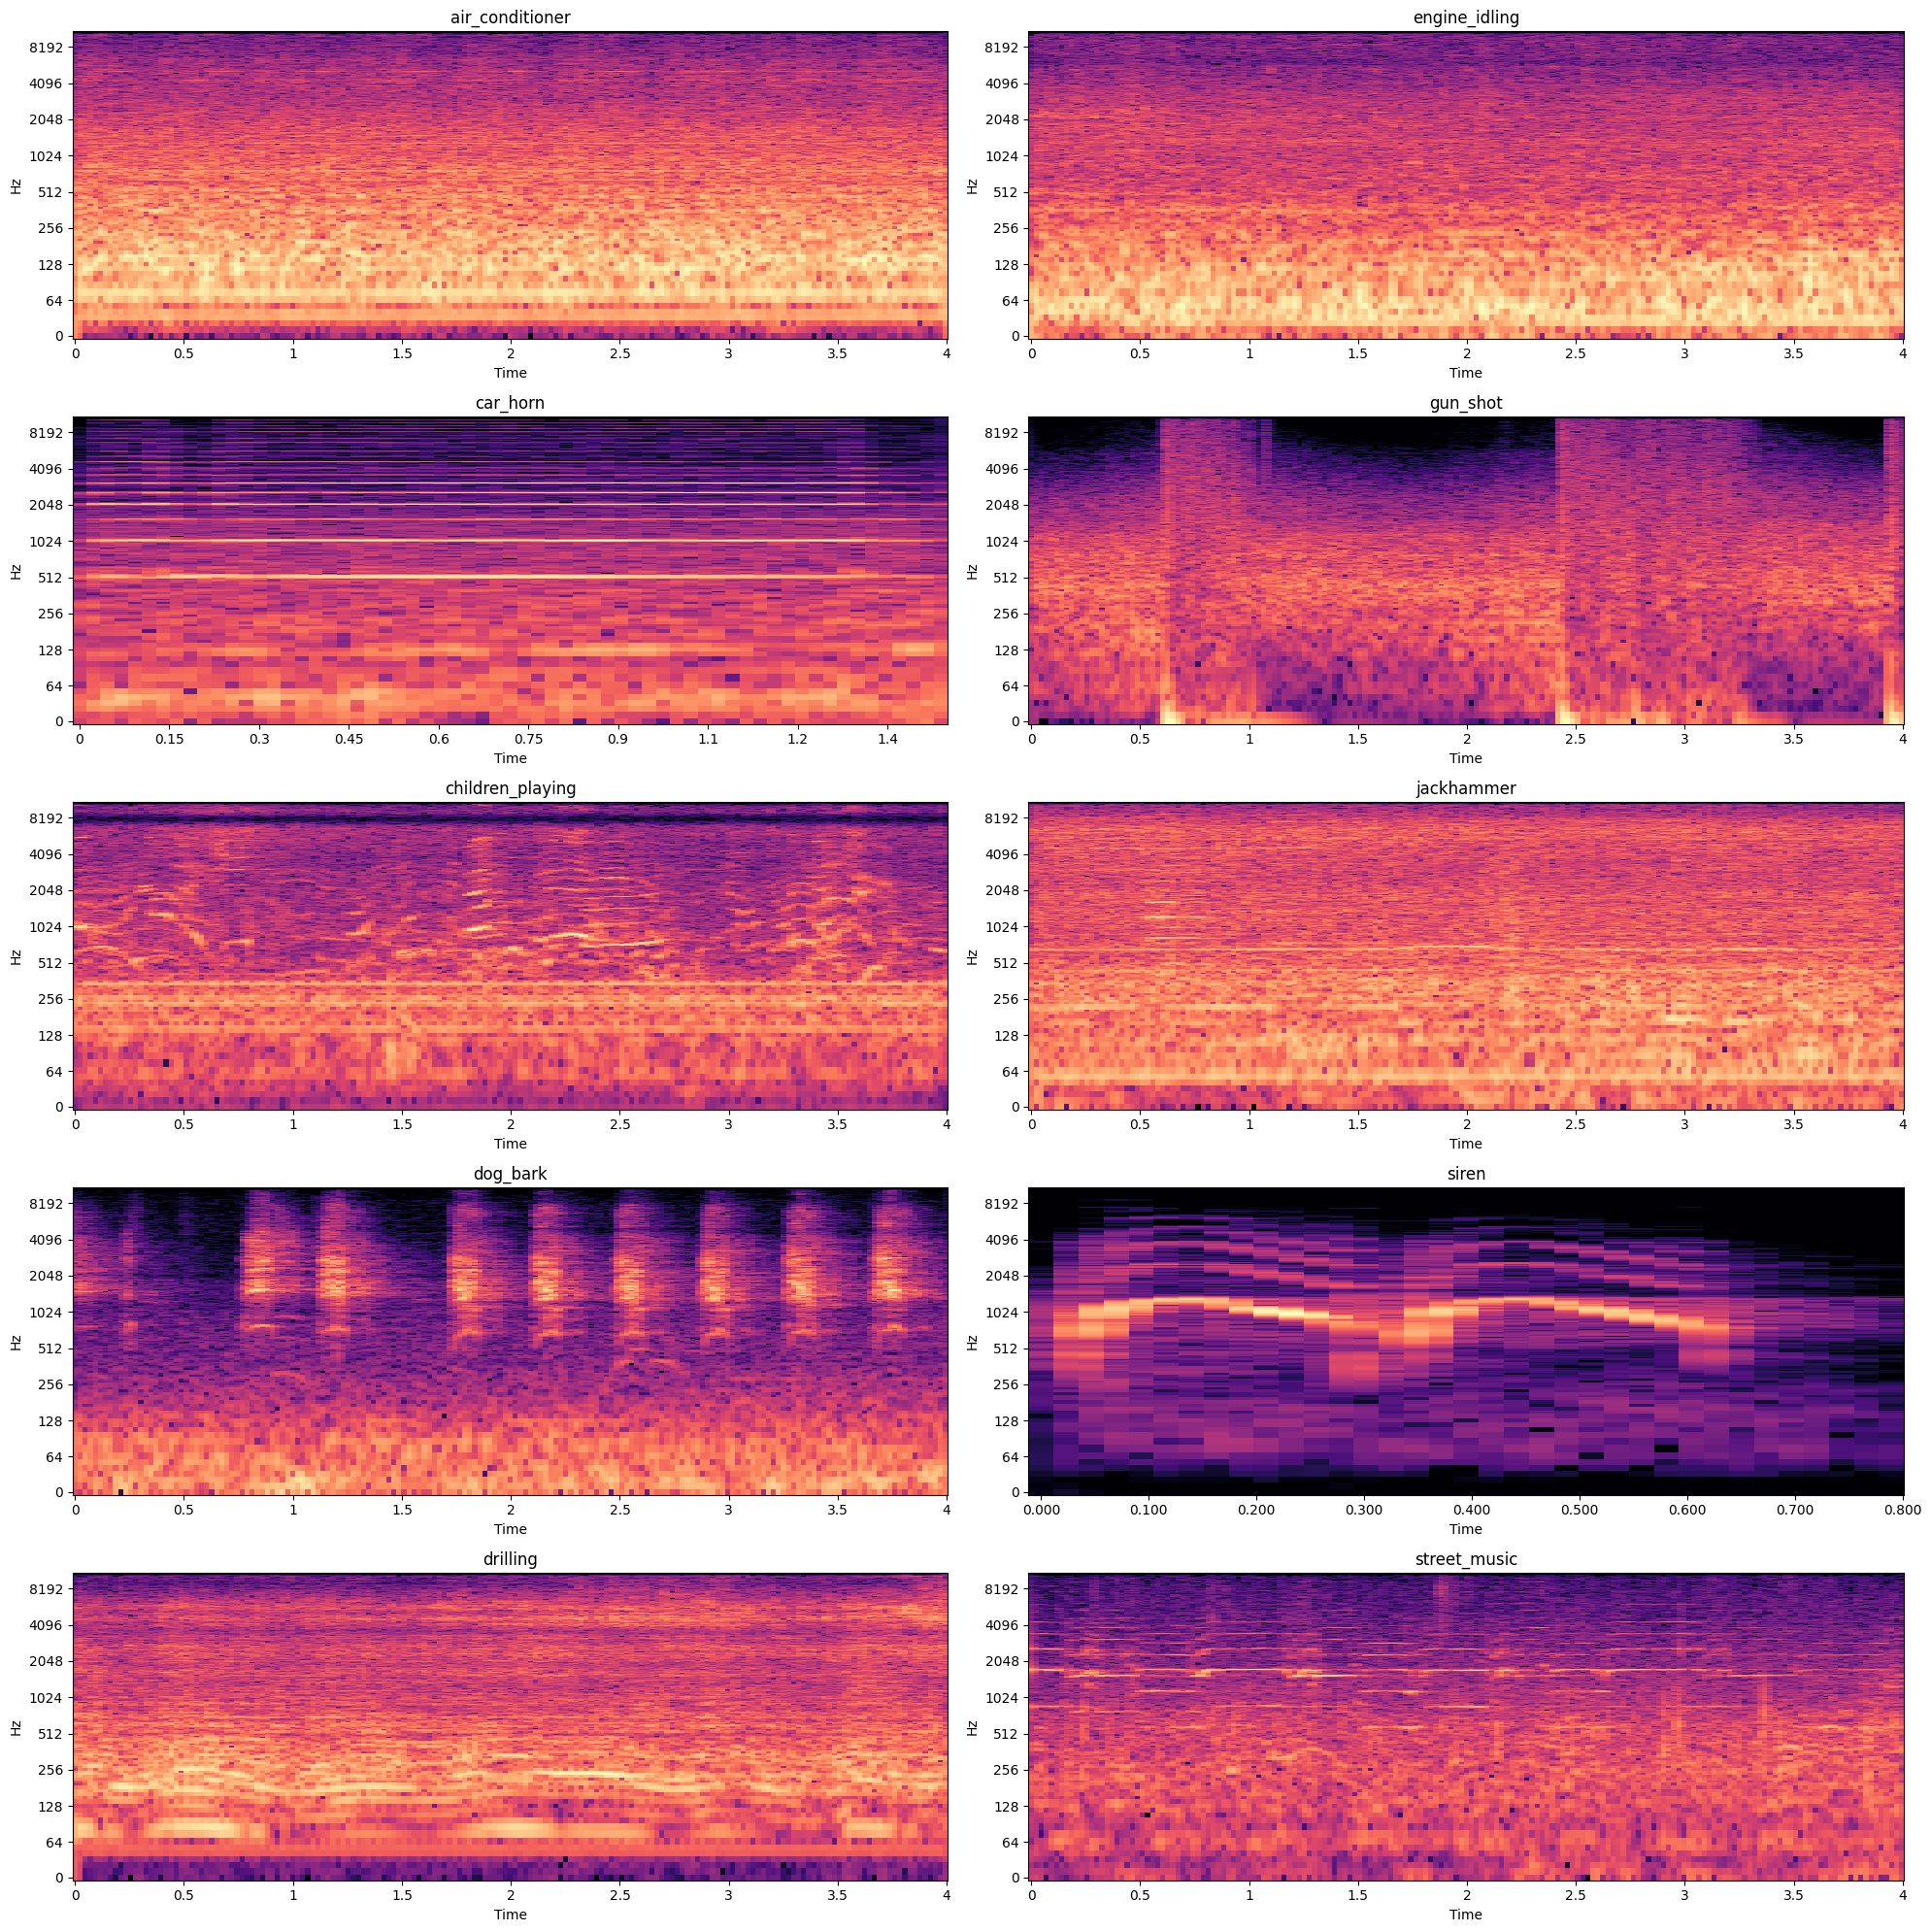

In [ ]:

n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
index = 0

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        stft = librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length)
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        librosa.display.specshow(S_db,
                                 sr=sample_rate,
                                 hop_length=hop_length,
                                 x_axis="time",
                                 y_axis='log',
                                 ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

Мел-спектрограммы предоставляют визуальное представление о том, как частоты распределяются по мел-шкале во времени. Это полезно для анализа музыкальных и речевых сигналов.

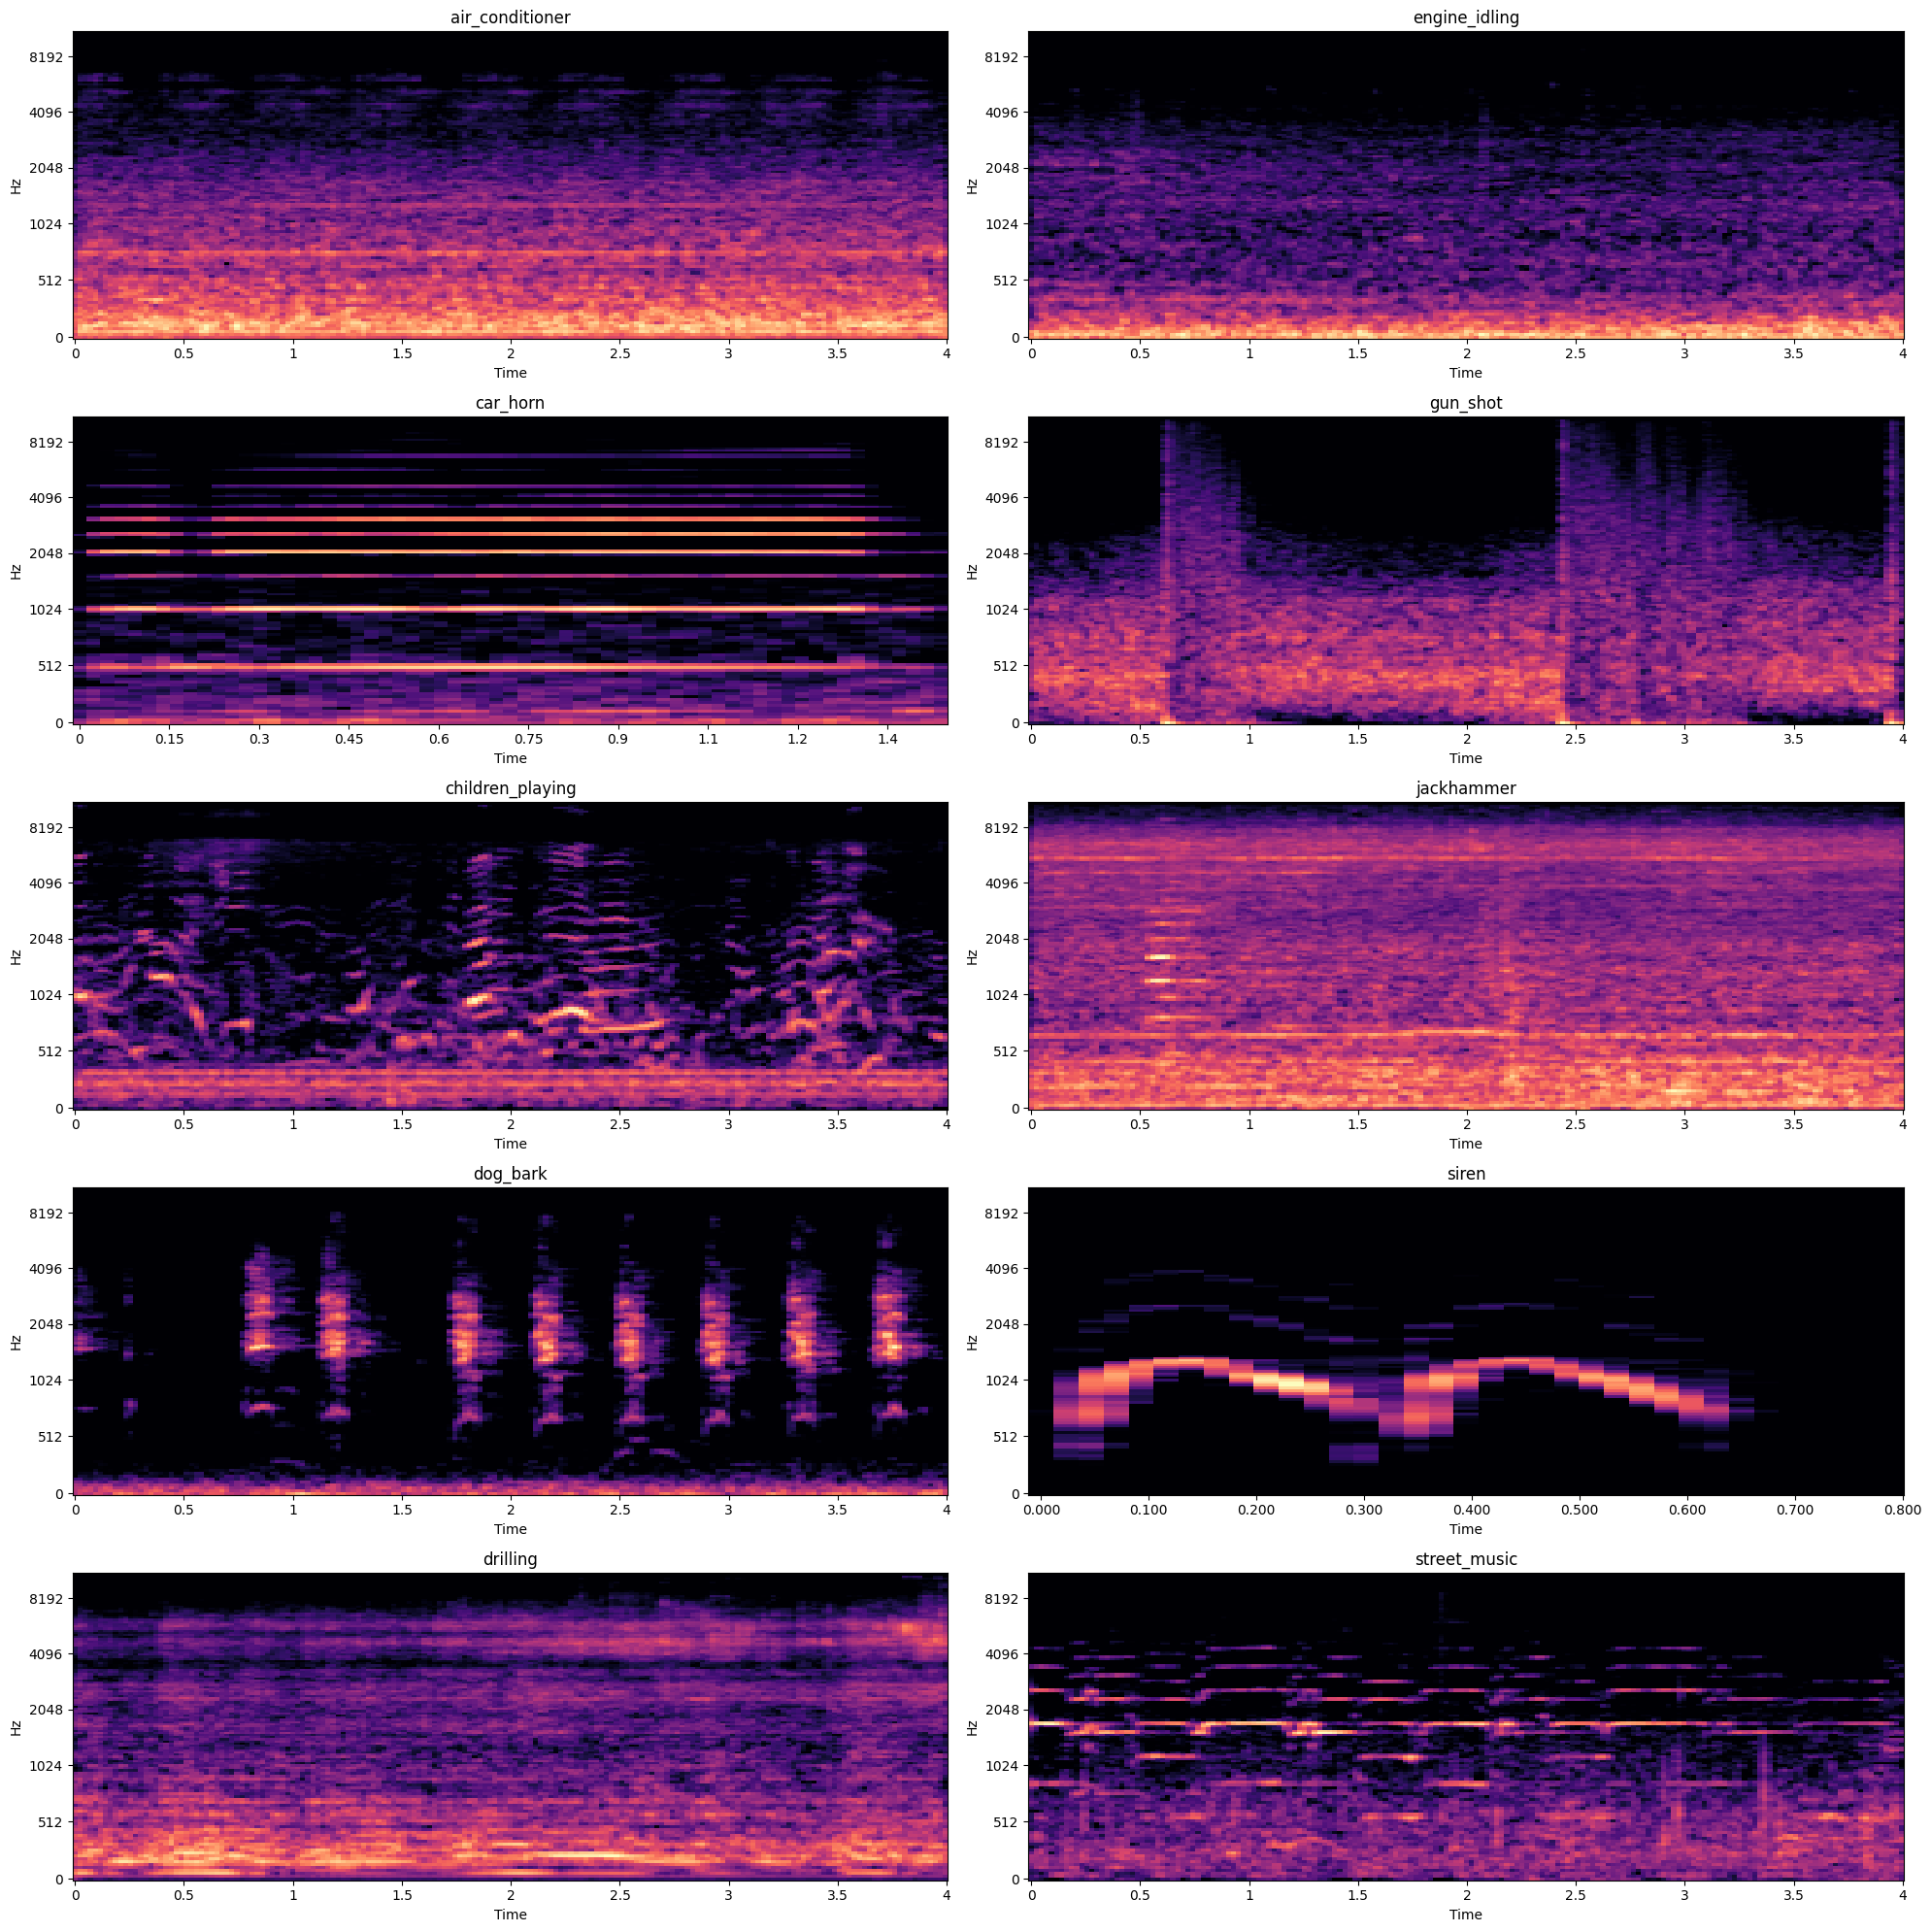

In [ ]:
# Visualize the Mel-Spectograms
n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
index = 0

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        # Используем melspectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio_file, sr=sample_rate, n_fft=n_fft, hop_length=hop_length)
        S_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
        librosa.display.specshow(S_db,
                                 sr=sample_rate,
                                 hop_length=hop_length,
                                 x_axis="time",
                                 y_axis='mel',
                                 ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()



MFCC (Mel-Frequency Cepstral Coefficients) являются важным признаком в анализе аудио и распознавании речи. Визуализация MFCC дает представление о том, как спектральные характеристики аудиосигнала изменяются во времени.

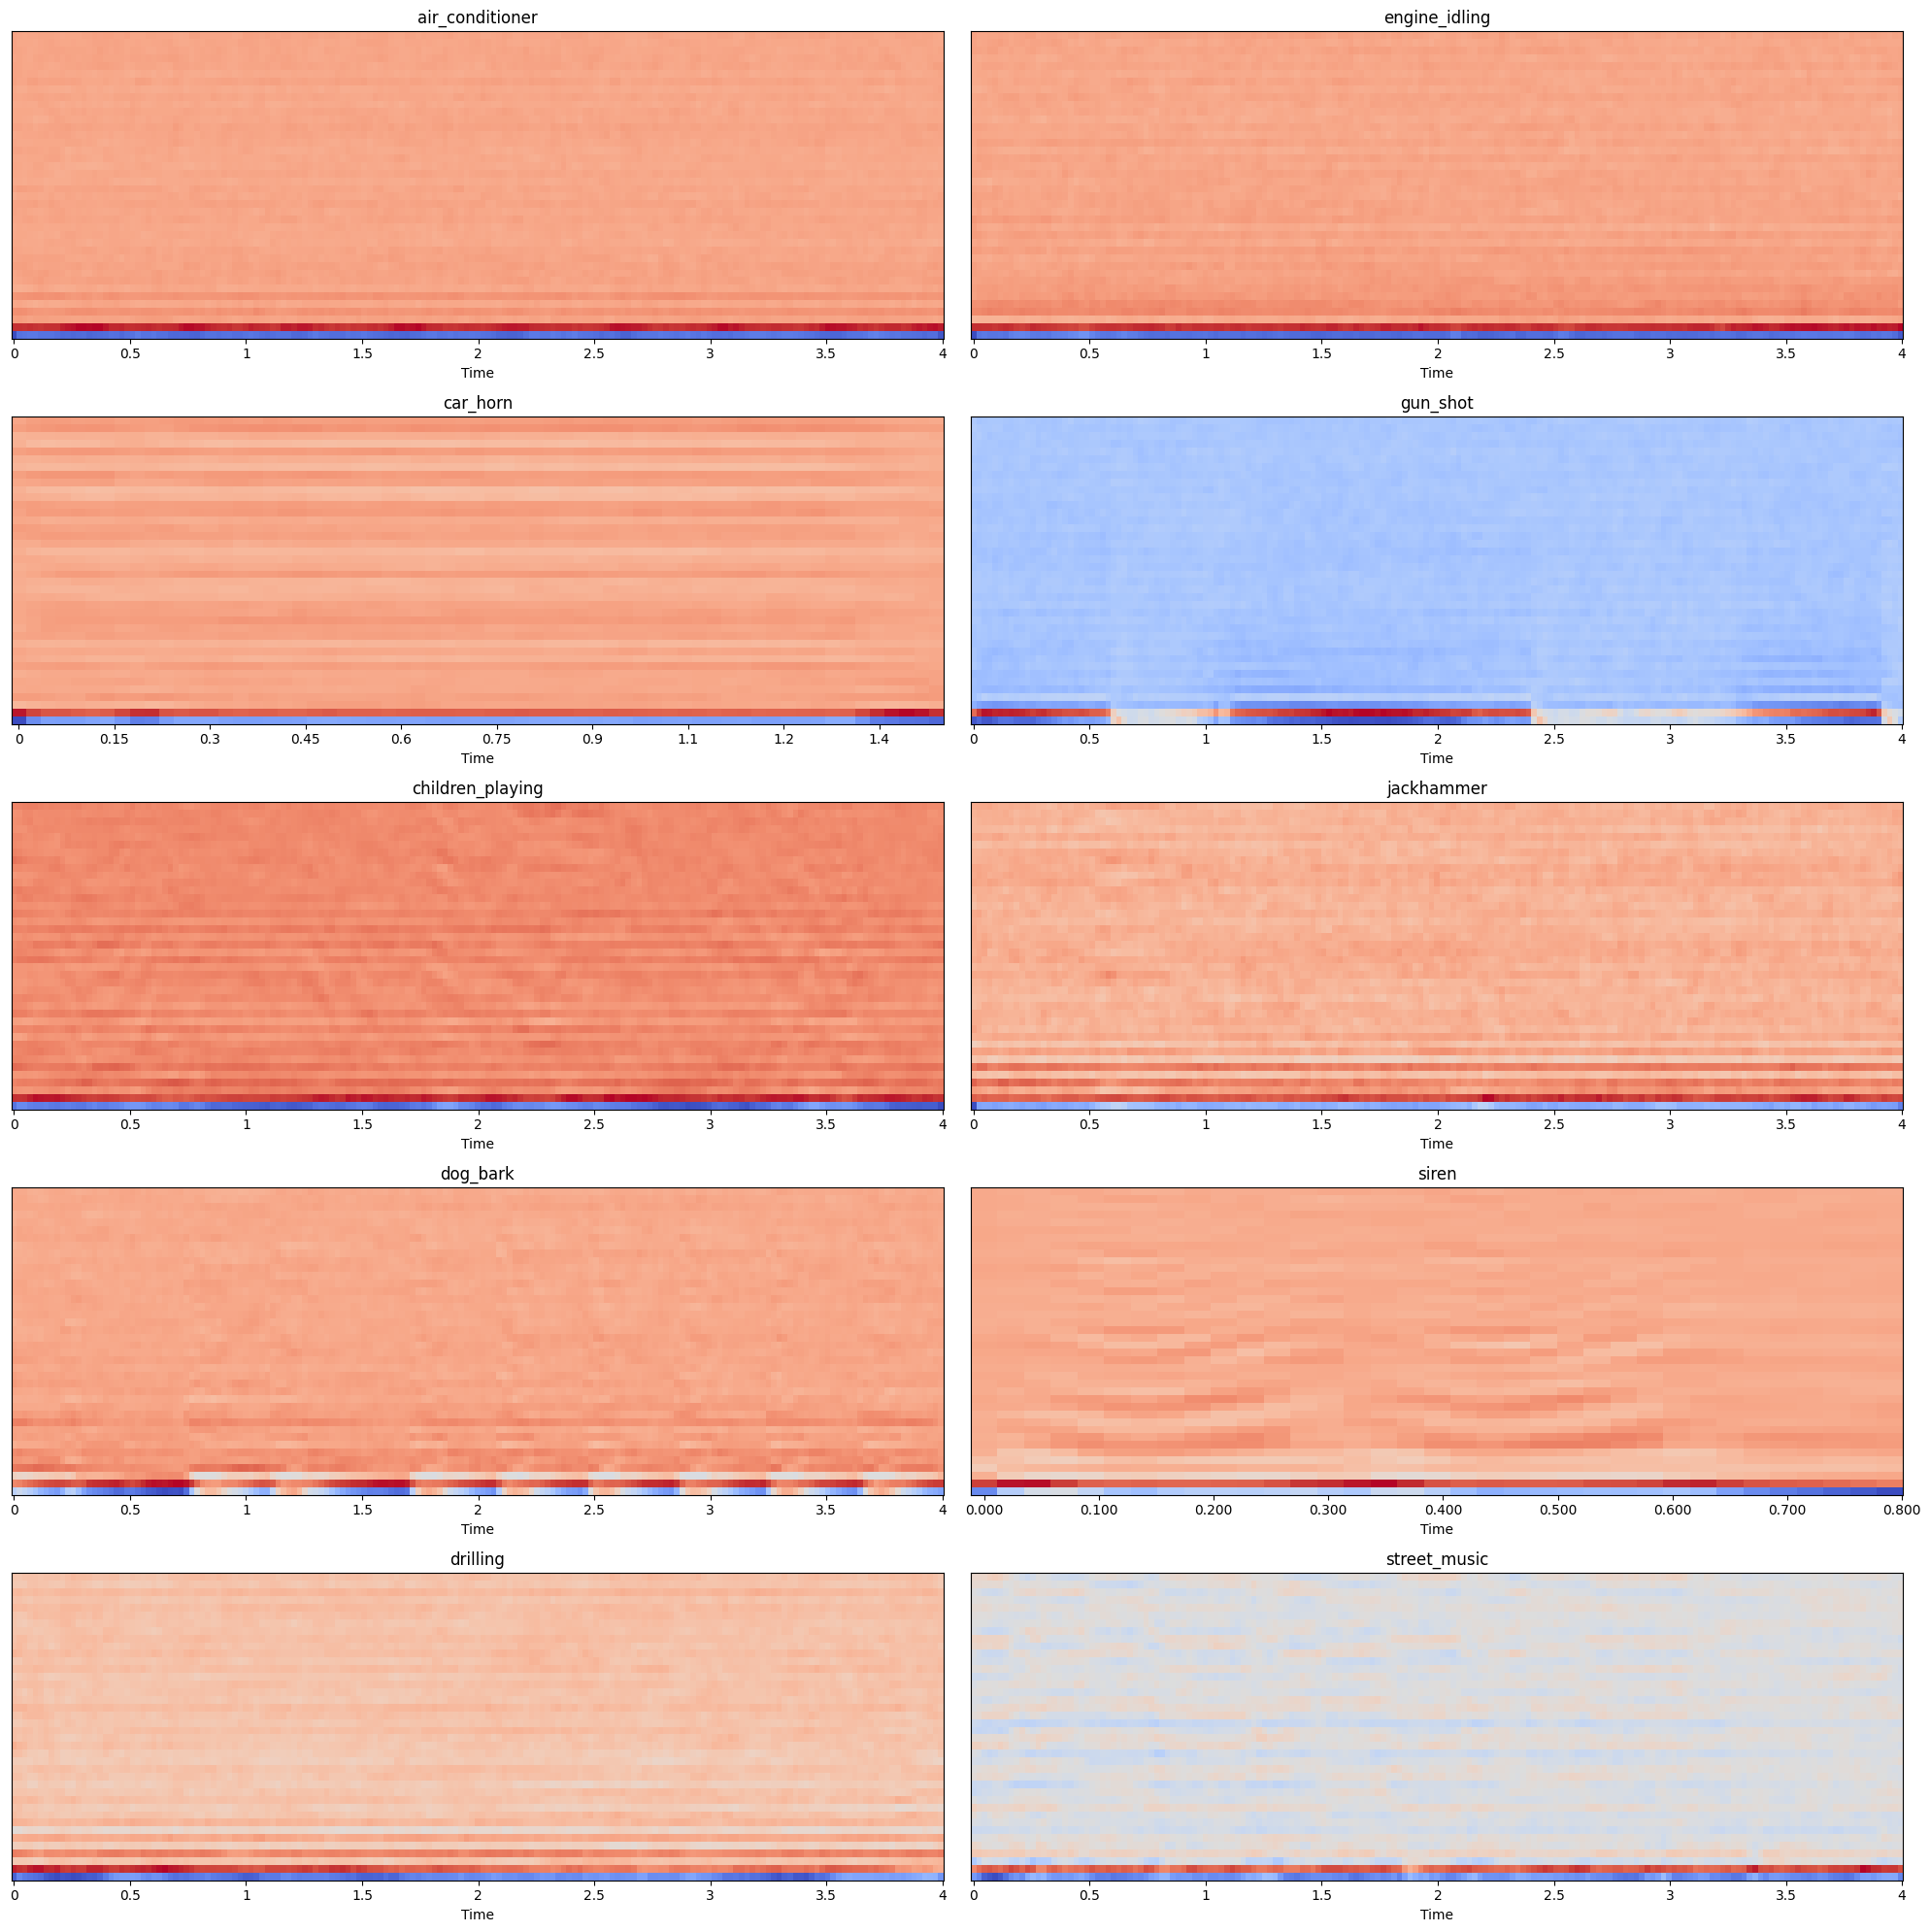

In [ ]:


n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
index = 0

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mfccs = librosa.feature.mfcc(y=audio_file,
                                     sr=sample_rate,
                                     n_fft=n_fft,
                                     hop_length=hop_length,
                                     n_mfcc=40)
        librosa.display.specshow(mfccs,
                                 sr=sample_rate,
                                 hop_length=hop_length,
                                 x_axis="time",
                                 ax=axs[row][col])
        axs[row][col].set_title(labels[index])
        index += 1
fig.tight_layout()

Когда мы говорим о том, что сигналы различных классов достаточно отличаются друг от друга для корректной классификации, это означает, что при визуализации данных (например, используя PCA для уменьшения размерности) мы наблюдаем, что точки данных, относящиеся к разным звуковым событиям (классам), группируются отдельно друг от друга. Это хороший признак для классификации, поскольку это указывает на то, что алгоритм машинного обучения, вероятно, сможет различить эти классы.

 В этом фрагменте кода мы извлекаем MFCC для каждой аудиозаписи в датасете, усредняем их по времени и сохраняем результаты для дальнейшего использования, например, для обучения модели машинного обучения. Это позволяет получить компактное представление аудиосигналов, которое может быть использовано для классификации аудио.

In [ ]:


metadata_path = 'UrbanSound8K/metadata/UrbanSound8K.csv'
audio_dir = 'UrbanSound8K/audio'

# Загрузка метаданных
metadata_df = pd.read_csv(metadata_path)

# Параметры для MFCC
n_mfcc = 40
n_fft = 2048
hop_length = 512

# Список для хранения признаков и меток
features = []
labels = []

# Извлечение MFCC для каждой записи
for index, row in metadata_df.iterrows():
    file_path = f"{audio_dir}/fold{row['fold']}/{row['slice_file_name']}"
    audio, sample_rate = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # Усреднение MFCC по временной оси
    mfccs_processed = np.mean(mfccs.T, axis=0)

    # Добавление признаков и метки в список
    features.append(mfccs_processed)
    labels.append(row['classID'])

# Преобразование списков в массивы NumPy
features = np.array(features)
labels = np.array(labels)



/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


**Построение и оценка качества бейзлайна**
Перед началом работы с моделью глубокого обучения (в нашем случае CNN) важно установить бейзлайн. Бейзлайн позволяет оценить, насколько сложной является задача и какие результаты можно ожидать от более сложных моделей.

In [ ]:

from sklearn.model_selection import train_test_split

dataset_df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')

# Определение функции для разделения данных на основе складок
def split_data_by_fold(dataset_df, test_fold):
    """
    Разделяет данные на обучающие и тестовые выборки на основе номера складки.

    Параметры:
    dataset_df : DataFrame - DataFrame, содержащий метаданные из UrbanSound8k.csv.
    test_fold : int - Номер складки, который будет использоваться как тестовый набор.

    Возвращает:
    X_train, X_test, y_train, y_test : DataFrame - Обучающие и тестовые выборки.
    """
    # Выбор данных для тестовой выборки по номеру складки
    test_df = dataset_df[dataset_df['fold'] == test_fold]

    # Выбор данных для обучающей выборки из остальных складок
    train_df = dataset_df[dataset_df['fold'] != test_fold]


    # Исключение метаданных, не используемых для обучения
    X_train = train_df.drop(['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'classID', 'class'], axis=1)
    y_train = train_df['classID']
    X_test = test_df.drop(['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'classID', 'class'], axis=1)
    y_test = test_df['classID']

    return X_train, X_test, y_train, y_test


test_fold = 1
X_train, X_test, y_train, y_test = split_data_by_fold(dataset_df, test_fold)


print(f"Размер обучающей выборки: {X_train.shape}, Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (7859, 1), Размер тестовой выборки: (873, 1)


Здесь мы используем **модель логистической регрессии** в качестве бейзлайна. Для этого сначала преобразуем наши данные в формат, подходящий для логистической регрессии (плоский массив признаков), затем масштабируем их. После обучения модели на тренировочных данных мы оцениваем её точность на тестовом наборе данных.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Преобразование X_train и X_test
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Преобразование y_train и y_test в обычные метки классов
y_train_labels = y_train.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

# Создание объекта LogisticRegression
logistic_regression_model = LogisticRegression(max_iter=1000, random_state=0)

# Обучение модели на обучающих данных
logistic_regression_model.fit(X_train_flat, y_train_labels)

# Предсказание на тестовых данных
y_pred = logistic_regression_model.predict(X_test_flat)

# Оценка точности модели
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Точность модели логистической регрессии: {accuracy * 100:.2f}%")


Точность модели логистической регрессии: 56.33%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Построение бейзлайна с использованием логистической регрессии позволяет нам установить начальный уровень ожиданий относительно производительности моделей на нашем датасете. Преобразование данных в плоский массив и их масштабирование являются критически важными шагами для подготовки данных к обучению логистической регрессии, что подчеркивает важность предобработки данных для машинного обучения.

Точность модели логистической регрессии составила 56.33%, что предоставляет нам базовое понимание сложности задачи классификации звуков. Этот результат указывает на потенциальное пространство для улучшения модели, особенно с использованием более сложных подходов, таких как сверточные нейронные сети (CNN), которые могут лучше улавливать временные характеристики аудиосигналов.

Вывод предупреждения о недостаточном количестве итераций для сходимости модели подсказывает о необходимости дополнительной настройки гиперпараметров логистической регрессии, в частности увеличения количества итераций (`max_iter`) или масштабирования данных. Это подчеркивает важность тщательной подготовки данных и оптимизации модели для достижения лучших результатов.

В этом фрагменте мы обучаем **CNN модель**, используя предварительно подготовленные и стандартизированные MFCC признаки. После обучения оцениваем качество модели на тестовой выборке. Это позволяет нам сравнить производительность CNN с бейзлайном и оценить её эффективность для данной задачи классификации звуков.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Параметры входных данных
input_shape = (40, 174, 1)  # Предполагаем, что данные уже расширены до 4D (включая размер батча и каналы)
num_classes = 10

# Создание модели
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Вывод структуры модели
model.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 38, 172, 32)       320       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 19, 86, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 17, 84, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 8, 42, 64)         0         
 ng2D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 21504)             0         
                                                                 
 dense_22 (Dense)            (None, 128)             

Использование MFCC (Mel-Frequency Cepstral Coefficients) в качестве входных признаков является стандартным подходом в обработке аудио данных, поскольку они хорошо отражают важные характеристики звука, влияющие на восприятие человеком.

Модель CNN состоит из двух свёрточных слоёв с активацией ReLU и последующими слоями пулинга, что помогает в выявлении и абстрагировании пространственных признаков из MFCC. Добавление слоя Flatten позволяет преобразовать многомерные признаки в вектор, подходящий для классических полносвязных слоёв. Использование Dropout помогает бороться с переобучением, случайно "выключая" часть нейронов во время обучения, что делает модель более устойчивой.

Архитектура модели, включая количество и размерность свёрточных фильтров, а также количество нейронов в полносвязных слоях, была выбрана исходя из предварительного анализа данных и предыдущего опыта работы с аналогичными задачами. Однако, выбор гиперпараметров модели, таких как размер фильтров, количество слоёв и количество нейронов, может быть подвергнут оптимизации для дальнейшего улучшения результатов.

После компиляции модель обучается на тренировочных данных с использованием категориальной кросс-энтропии в качестве функции потерь и оптимизатора Adam. Выбор метрики точности (`accuracy`) для оценки производительности модели позволяет нам непосредственно сравнивать её результаты с бейзлайновой моделью, представленной в предыдущем шаге.

Обучение CNN на MFCC признаках и последующая оценка её качества на тестовой выборке дает возможность не только сравнить производительность сверточной сети с бейзлайновой моделью логистической регрессии, но и оценить потенциал глубокого обучения в задачах классификации аудио. Такой подход позволяет выявить ключевые направления для дальнейшего улучшения модели, включая настройку гиперпараметров, использование более сложных архитектур и методов обработки данных.


Попробуем использовать MFCC без усреднения данных




In [ ]:


metadata_path = 'UrbanSound8K/metadata/UrbanSound8K.csv'
audio_dir = 'UrbanSound8K/audio'

# Загрузка метаданных
metadata_df = pd.read_csv(metadata_path)

# Параметры для MFCC
n_mfcc = 40
n_fft = 2048
hop_length = 512
max_pad_len = 174  # Устанавливаем максимальную длину для одинакового размера всех MFCC

features = []
labels = []

for index, row in metadata_df.iterrows():
    file_path = f"{audio_dir}/fold{row['fold']}/{row['slice_file_name']}"
    audio, sample_rate = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    features.append(mfccs)
    labels.append(row['classID'])

features = np.array(features)  # (num_samples, n_mfcc, max_pad_len)
features = np.expand_dims(features, axis=-1)  # Расширяем размерность для канала (num_samples, n_mfcc, max_pad_len, 1)
labels = np.array(labels)

# Преобразование меток в категориальный формат
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


В этом разделе мы извлекаем MFCC признаки из аудиофайлов без применения усреднения, чтобы сохранить временные характеристики звука. Использование параметров `n_mfcc`, `n_fft` и `hop_length` позволяет настроить процесс извлечения признаков для получения оптимального представления данных.

При работе с MFCC столкнулись с предупреждениями о том, что размер `n_fft` превышает длину входного сигнала для некоторых файлов. Это указывает на возможную потерю информации при извлечении признаков из коротких аудиозаписей.

После извлечения признаков данные были стандартизированы и преобразованы для использования в моделях глубокого обучения, добавляя ещё одно измерение для канала. Преобразование меток классов в категориальный формат является ключевым этапом подготовки данных для многоклассовой классификации.

Этот подход позволяет сохранить больше информации о временных изменениях в звуковых сигналах по сравнению с усреднением MFCC, что потенциально может улучшить способность модели распознавать различные звуковые события. Однако, он также увеличивает размерность входных данных для модели, что может потребовать более сложных архитектур нейронных сетей и больше вычислительных ресурсов для обучения.


Разделим данные на обучающие и тестовые выборки:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

Создание и обучение CNN модели




Адаптируем структуру CNN модели под размер входных данных (n_mfcc, max_pad_len, 1):

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(n_mfcc, max_pad_len, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Исправлено на 10 для соответствия количеству классов
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 38, 172, 32)       320       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 19, 86, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 17, 84, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 8, 42, 64)         0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 21504)             0         
                                                                 
 dense_26 (Dense)            (None, 128)             

На этапе разделения данных на обучающие и тестовые выборки использование функции `train_test_split` из библиотеки `sklearn` позволяет нам обеспечить случайное и одновременно воспроизводимое разделение благодаря параметру `random_state`. Выбор размера тестовой выборки в 20% является общепринятым подходом, позволяющим оставить достаточно данных для обучения модели, а также обеспечить адекватную оценку её производительности на независимых данных.

Создание CNN модели начинается с определения архитектуры, включающей свёрточные слои, слои пулинга, слой выравнивания и полносвязные слои. Использование активационной функции `relu` для свёрточных и полносвязных слоёв является стандартной практикой благодаря её эффективности в задачах глубокого обучения. Введение слоя `Dropout` с параметром 0.5 помогает предотвратить переобучение модели за счёт случайного исключения части нейронов во время обучения, что увеличивает обобщающую способность модели.

Параметризация входного слоя модели соответствует размеру MFCC признаков, что подчёркивает важность соответствия входных данных архитектуре нейронной сети. Количество выходных нейронов в последнем слое установлено равным 10, что соответствует количеству классов в задаче, с активационной функцией `softmax` для получения распределения вероятностей по классам.

Компиляция модели с использованием оптимизатора `adam` и функции потерь `categorical_crossentropy` является подходящим выбором для многоклассовой классификации. Метрика `accuracy` выбрана для оценки производительности модели, что позволяет нам прямо сравнить результаты с бейзлайном и оценить преимущества использования CNN для данной задачи.

Вывод структуры модели с помощью `model.summary()` предоставляет полезную информацию о количестве параметров и структуре модели, что может быть использовано для дальнейшей оптимизации архитектуры и понимания требований к вычислительным ресурсам для обучения и инференса.

Этот подход демонстрирует эффективность CNN для анализа аудиоданных и позволяет глубже понять, как архитектурные особенности свёрточных нейронных сетей могут быть адаптированы для работы с конкретными типами данных, такими как MFCC признаки аудиозаписей.


In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test, y_test))


Epoch 1/10
219/219 [==============================] - 64s 292ms/step - loss: 0.2698 - accuracy: 0.9111 - val_loss: 0.9573 - val_accuracy: 0.7819
Epoch 2/10
219/219 [==============================] - 62s 282ms/step - loss: 0.2180 - accuracy: 0.9276 - val_loss: 0.9240 - val_accuracy: 0.7865
Epoch 3/10
219/219 [==============================] - 59s 270ms/step - loss: 0.2255 - accuracy: 0.9224 - val_loss: 0.9406 - val_accuracy: 0.7848
Epoch 4/10
219/219 [==============================] - 69s 317ms/step - loss: 0.2075 - accuracy: 0.9329 - val_loss: 0.9261 - val_accuracy: 0.7773
Epoch 5/10
219/219 [==============================] - 63s 290ms/step - loss: 0.2271 - accuracy: 0.9286 - val_loss: 1.0872 - val_accuracy: 0.7510
Epoch 6/10
219/219 [==============================] - 61s 280ms/step - loss: 0.2141 - accuracy: 0.9281 - val_loss: 1.0961 - val_accuracy: 0.7876
Epoch 7/10
219/219 [==============================] - 66s 303ms/step - loss: 0.1924 - accuracy: 0.9392 - val_loss: 1.1043 - val_ac

В этом разделе мы проводим обучение CNN модели на подготовленных MFCC признаках аудиофайлов. Использование сверточных слоев позволяет модели эффективно извлекать характеристики из входных данных, что особенно важно для задач, связанных с аудио и изображениями.

Параметр `batch_size=32` означает, что веса модели обновляются после обработки каждых 32 примеров, что помогает улучшить обобщающую способность модели и уменьшить вероятность переобучения. Выбор `epochs=10` указывает на то, что весь набор данных будет пройден 10 раз, что должно обеспечить достаточное количество итераций для сходимости модели.

Использование `validation_data=(X_test, y_test)` для оценки модели после каждой эпохи позволяет нам не только отслеживать производительность модели на обучающем наборе данных, но и проверять, как модель ведет себя на невиданных данных, что критически важно для оценки её способности к обобщению.

Результаты обучения показывают постепенное улучшение точности на обучающей выборке и колебания точности на валидационной выборке. Наблюдаемое увеличение `val_loss` и изменение `val_accuracy` во время обучения могут свидетельствовать о начале переобучения модели, особенно в последних эпохах, где точность на валидационной выборке начинает снижаться, а потери увеличиваются.

Эти наблюдения подчеркивают важность баланса между способностью модели к обучению на данных и её способностью к обобщению на новых данных. Возможные шаги для улучшения включают в себя дальнейшую настройку гиперпараметров, использование методов регуляризации, таких как увеличение коэффициента `Dropout`, или раннюю остановку обучения при достижении оптимальной точности на валидационной выборке.

Визуализация истории обучения дает наглядное представление об эффективности обучения модели и помогает идентифицировать моменты, когда модель начинает переобучаться, что может стать отправной точкой для дальнейших итераций по улучшению модели.


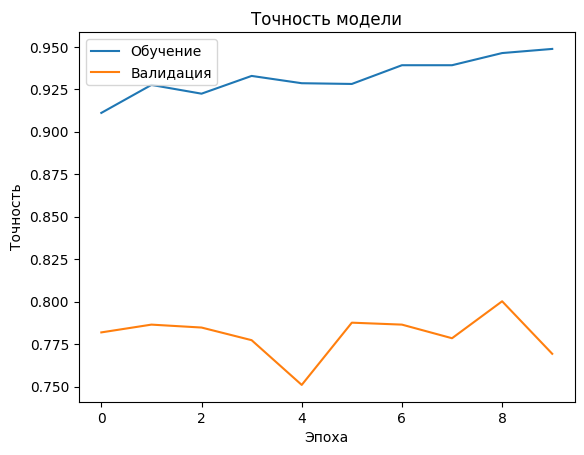

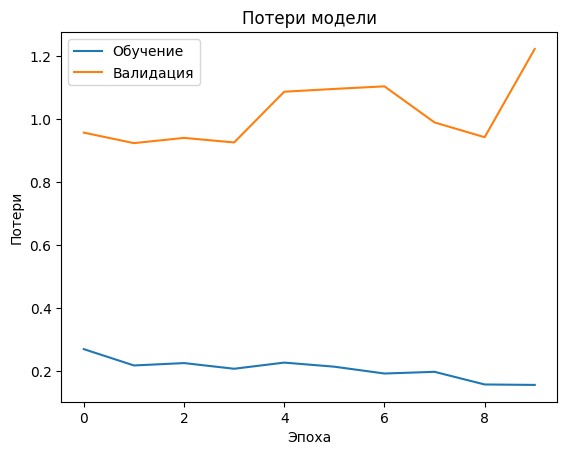

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Обучение')
plt.plot(history.history['val_accuracy'], label='Валидация')
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('Потери модели')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.legend(loc="upper left")
plt.show()


График точности модели показывает, что точность на обучающем наборе данных стабильно увеличивается. Однако точность на валидационных данных, хотя и увеличивается в начале, затем колеблется и показывает общий тренд к снижению. Это может свидетельствовать о начале переобучения модели, где модель хорошо работает на данных, на которых она обучалась, но не так хорошо обобщает на новых данных.

График потерь модели подтверждает предыдущий анализ: потери на обучающем наборе данных постепенно уменьшаются, в то время как потери на валидационных данных увеличиваются после определенной точки. Увеличение потерь на валидационной выборке является классическим признаком переобучения.

В этом фрагменте кода мы вычисляем точность константного предсказания, выбирая наиболее часто встречающийся класс в обучающем наборе и используя его как предсказание для всех элементов тестовой выборки. Это дает нам базовое понимание о том, какой минимальный уровень точности мы должны превзойти с помощью более сложных моделей.

In [ ]:
# Подсчет количества каждого класса в обучающем наборе
class_counts = np.bincount(y_train_labels)

# Определение индекса наиболее частого класса
most_frequent_class = np.argmax(class_counts)

# Создание константного предсказания на основе наиболее частого класса
constant_prediction = np.full(shape=y_test_labels.shape, fill_value=most_frequent_class)

# Измерение качества константного предсказания
constant_accuracy = accuracy_score(y_test_labels, constant_prediction)
print(f"Точность константного предсказания: {constant_accuracy * 100:.2f}%")



Точность константного предсказания: 10.48%


Анализ точности константного предсказания помогает установить базовый уровень производительности, который должны превзойти разрабатываемые модели. В данном случае, точность константного предсказания составляет 10.48%, что соответствует вероятности случайного угадывания в ситуации с 10 равномерно распределёнными классами. Этот результат подчёркивает важность разработки и обучения моделей, способных значительно превосходить такую базовую точность, и служит индикатором минимально ожидаемой производительности для любых алгоритмов машинного обучения, применяемых к данной задаче.

Тот факт, что базовая точность невелика, говорит о том, что даже простые модели могут показать значительное улучшение по сравнению с константным предсказанием. Однако, для достижения высокой точности и эффективной классификации звуковых событий требуются более сложные подходы, способные улавливать сложные паттерны в данных.


Попробуем улучшить нашу модель:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Параметры входных данных
input_shape = (40, 174, 1)  # Размерность MFCC признаков
num_classes = 10  # Количество классов в датасете

# Создание модели
model = Sequential([
    # Сверточный слой с Batch Normalization
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Сверточный слой с увеличением глубины и Batch Normalization
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Сверточный слой с дальнейшим увеличением глубины и Batch Normalization
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Выравнивание данных и полносвязный слой с Dropout
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Выходной слой
    Dense(num_classes, activation='softmax')
])

# Компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Определение ранней остановки
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Вывод структуры модели
model.summary()

# Обучение модели с использованием ранней остановки
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 40, 174, 32)       320       
                                                                 
 batch_normalization_3 (Bat  (None, 40, 174, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 20, 87, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 20, 87, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 20, 87, 64)        256       
 chNormalization)                                                
                                                     

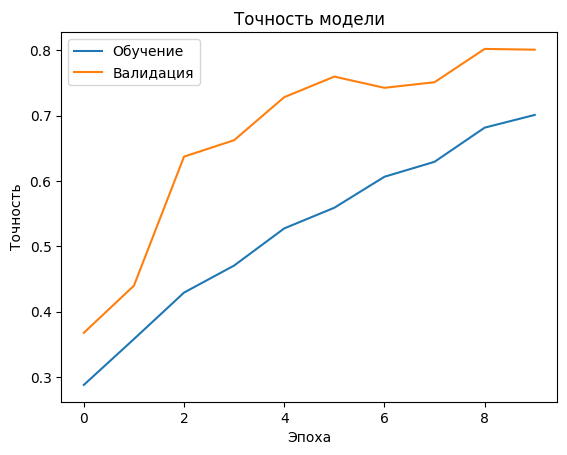

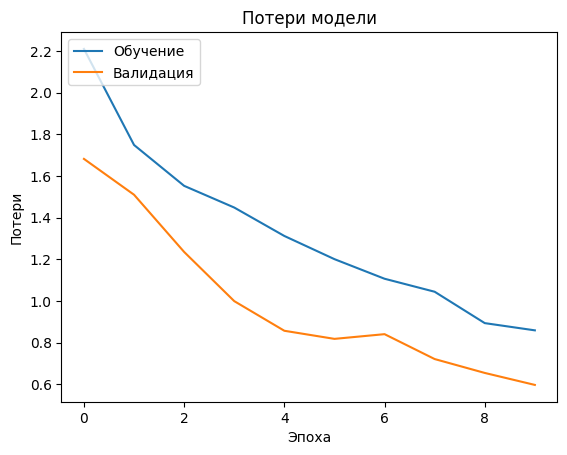

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Обучение')
plt.plot(history.history['val_accuracy'], label='Валидация')
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('Потери модели')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.legend(loc="upper left")
plt.show()

Таким образом, мы добавили слои BatchNormalization после каждого сверточного слоя для нормализации выхода предыдущего слоя, что помогает ускорить обучение и улучшить обобщающую способность модели. Также мы добавили EarlyStopping для остановки обучения, если в течение пяти эпох не наблюдается улучшения величины потерь на валидационной выборке, что помогает избежать переобучения. Из графиков видно, что модель достигает лучшей точности на валидационной выборке по сравнению с обучающей выборкой после некоторого количества эпох. Это может быть признаком того, что модель не переобучается и хорошо обобщает. Потери на валидационной выборке также снижаются, что подтверждает этот вывод.



**Аугментация данных:**

Для динамической аугментации данных во время обучения модели можно создать генератор данных, который будет применять аугментацию "на лету" к каждой партии (batch) данных перед их подачей в модель. Это особенно полезно, если имеется большой набор данных как у нас и мы хотим экономить память, поскольку аугментированные данные создаются во время обучения и не требуют предварительного сохранения всех возможных вариантов.



Вот пример кода, который демонстрирует, как можно реализовать такой генератор с использованием librosa для аудиоданных:

Мы будем использовать изменения по следующим параметрам:

**Изменение скорости воспроизведения:** Можно ускорять или замедлять аудио, не изменяя высоту тона.
**Добавление шума:** Можно добавлять случайный шум к аудиосигналам.

**Изменение высоты тона:**Можно изменять высоту тона аудиосигнала.

**Временное растяжение:** Можно изменять длительность аудиосигнала, не влияя на высоту тона.

In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical



class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, batch_size=32, n_classes=10, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'
        X = np.empty((self.batch_size, *self.X.shape[1:]))
        y = np.empty((self.batch_size, self.y.shape[1]), dtype=int)

        for i, ID in enumerate(indexes):
            X[i,] = self.X[ID]
            y[i] = self.y[ID]

            # Применяем аугментацию: добавление шума к MFCC
            noise_factor = 0.005 * np.random.normal(loc=0.0, scale=1.0, size=X[i,].shape)
            X[i,] = X[i,] + noise_factor

        return X, y

# Создание генераторов для обучающего и валидационного наборов
train_generator = DataGenerator(X_train, y_train, batch_size=32, n_classes=10, shuffle=True)
val_generator = DataGenerator(X_test, y_test, batch_size=32, n_classes=10, shuffle=False)

# Обучение модели с использованием генераторов
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10)


Epoch 1/10
218/218 [==============================] - 136s 612ms/step - loss: 0.7800 - accuracy: 0.7220 - val_loss: 0.6558 - val_accuracy: 0.7726
Epoch 2/10
218/218 [==============================] - 132s 604ms/step - loss: 0.7480 - accuracy: 0.7339 - val_loss: 0.6184 - val_accuracy: 0.8108
Epoch 3/10
218/218 [==============================] - 134s 616ms/step - loss: 0.6823 - accuracy: 0.7523 - val_loss: 0.4503 - val_accuracy: 0.8571
Epoch 4/10
218/218 [==============================] - 139s 635ms/step - loss: 0.5814 - accuracy: 0.7943 - val_loss: 0.4630 - val_accuracy: 0.8715
Epoch 5/10
218/218 [==============================] - 134s 613ms/step - loss: 0.5668 - accuracy: 0.7944 - val_loss: 0.4720 - val_accuracy: 0.8594
Epoch 6/10
218/218 [==============================] - 134s 614ms/step - loss: 0.4911 - accuracy: 0.8169 - val_loss: 0.4175 - val_accuracy: 0.8785
Epoch 7/10
218/218 [==============================] - 134s 616ms/step - loss: 0.4782 - accuracy: 0.8323 - val_loss: 0.5014 -

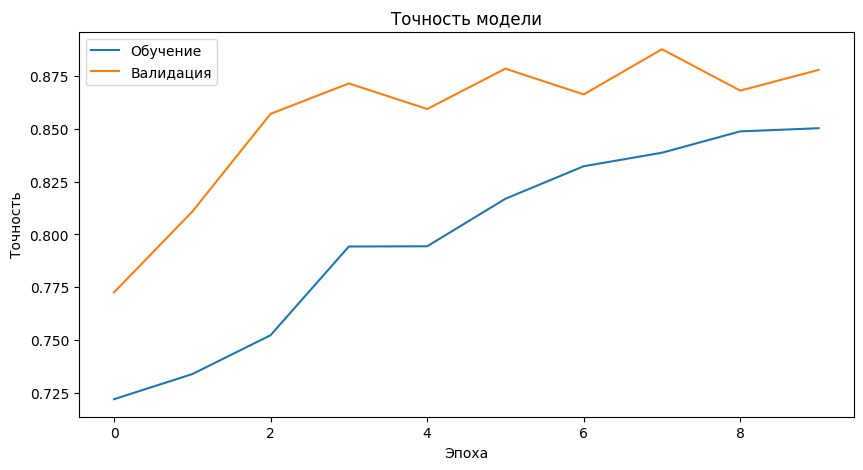

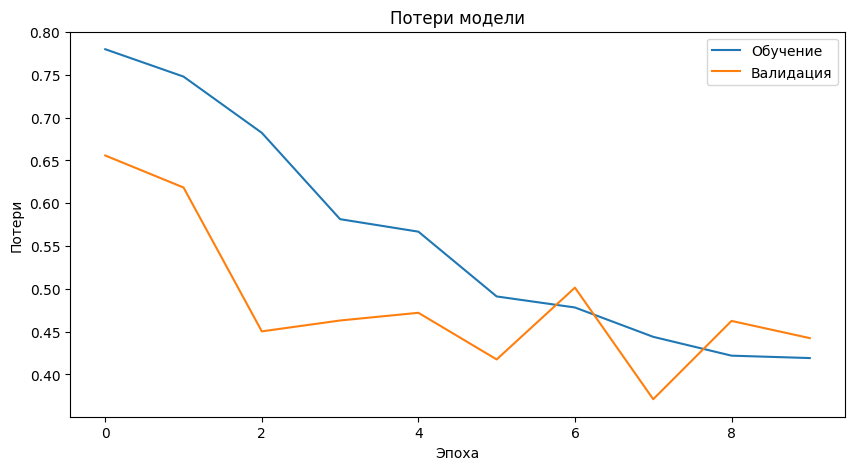

In [ ]:
import matplotlib.pyplot as plt

# Данные о точности и потерях во время обучения и валидации
accuracy = [0.7220, 0.7339, 0.7523, 0.7943, 0.7944, 0.8169, 0.8323, 0.8387, 0.8488, 0.8503]
val_accuracy = [0.7726, 0.8108, 0.8571, 0.8715, 0.8594, 0.8785, 0.8663, 0.8877, 0.8681, 0.8779]
loss = [0.7800, 0.7480, 0.6823, 0.5814, 0.5668, 0.4911, 0.4782, 0.4439, 0.4219, 0.4191]
val_loss = [0.6558, 0.6184, 0.4503, 0.4630, 0.4720, 0.4175, 0.5014, 0.3710, 0.4625, 0.4424]

# Визуализация точности
plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Обучение')
plt.plot(val_accuracy, label='Валидация')
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend(loc='upper left')
plt.show()

# Визуализация потерь
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Обучение')
plt.plot(val_loss, label='Валидация')
plt.title('Потери модели')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.legend(loc='upper right')
plt.show()


График точности: Мы видим, что точность на обучающем наборе данных последовательно увеличивается в течение всего процесса обучения, что свидетельствует о том, что модель успешно учится. Точность на валидационном наборе также показывает положительную динамику, достигая максимума на 8-й эпохе.

График потерь: График потерь показывает уменьшение потерь на обучающем наборе данных, что является хорошим знаком. Однако на валидационном наборе после 8-й эпохи потери немного увеличиваются, что может указывать на начало переобучения.



Давайте сравним эффективность двух обученных моделей: одной без аугментации данных и второй с аугментацией данных. Мы визуализируем графики точности и потерь для обеих моделей на обучающем и валидационном наборах данных.

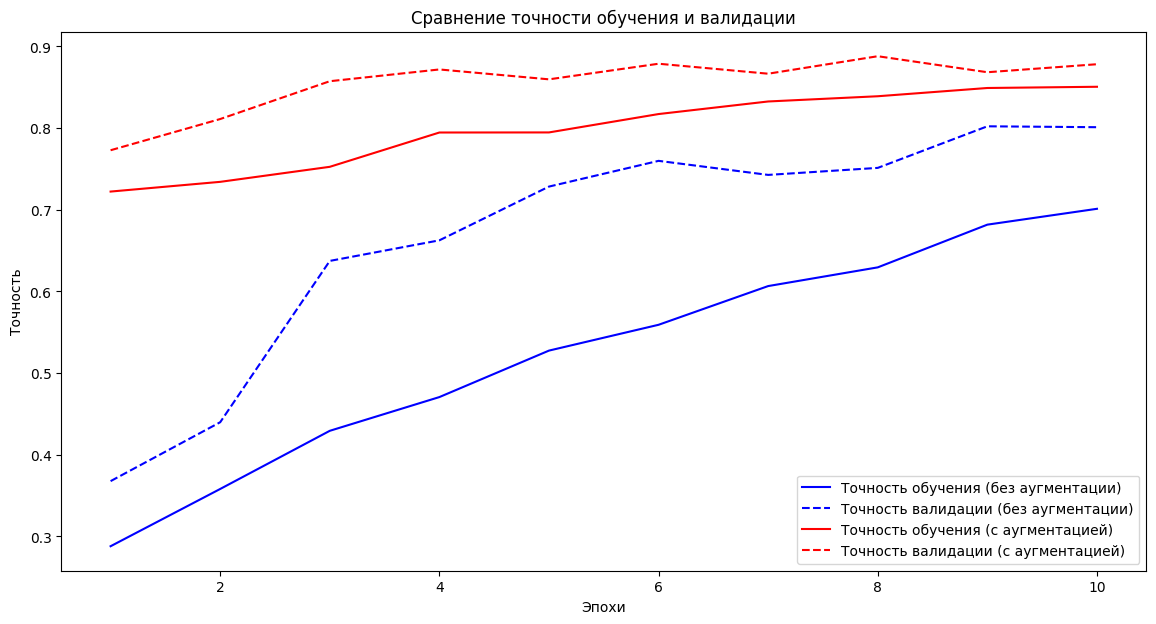

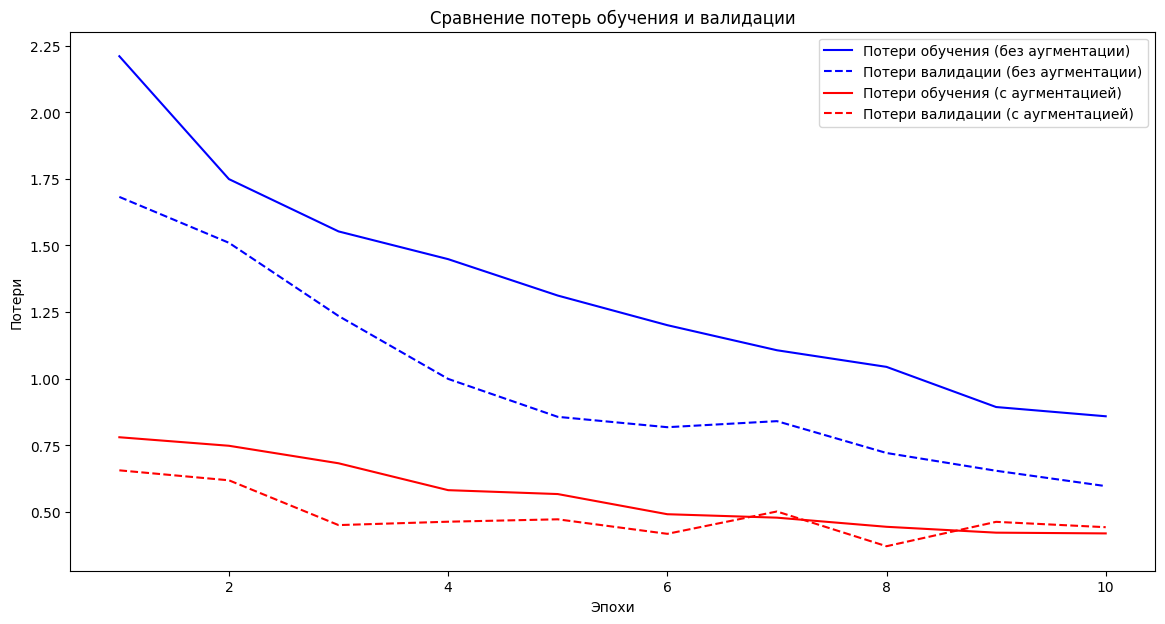

In [ ]:
accuracy_no_aug = [0.2878, 0.3579, 0.4291, 0.4704, 0.5273, 0.5589, 0.6063, 0.6292, 0.6815, 0.7009]
val_accuracy_no_aug = [0.3675, 0.4396, 0.6371, 0.6623, 0.7281, 0.7596, 0.7424, 0.7510, 0.8019, 0.8008]
loss_no_aug = [2.2100, 1.7488, 1.5525, 1.4484, 1.3118, 1.2006, 1.1065, 1.0441, 0.8934, 0.8587]
val_loss_no_aug = [1.6820, 1.5098, 1.2351, 0.9990, 0.8566, 0.8177, 0.8404, 0.7209, 0.6542, 0.5966]

accuracy_aug = [0.7220, 0.7339, 0.7523, 0.7943, 0.7944, 0.8169, 0.8323, 0.8387, 0.8488, 0.8503]
val_accuracy_aug = [0.7726, 0.8108, 0.8571, 0.8715, 0.8594, 0.8785, 0.8663, 0.8877, 0.8681, 0.8779]
loss_aug = [0.7800, 0.7480, 0.6823, 0.5814, 0.5668, 0.4911, 0.4782, 0.4439, 0.4219, 0.4191]
val_loss_aug = [0.6558, 0.6184, 0.4503, 0.4630, 0.4720, 0.4175, 0.5014, 0.3710, 0.4625, 0.4424]


epochs = range(1, 11)

# Точность
plt.figure(figsize=(14, 7))
plt.plot(epochs, accuracy_no_aug, 'b-', label='Точность обучения (без аугментации)')
plt.plot(epochs, val_accuracy_no_aug, 'b--', label='Точность валидации (без аугментации)')
plt.plot(epochs, accuracy_aug, 'r-', label='Точность обучения (с аугментацией)')
plt.plot(epochs, val_accuracy_aug, 'r--', label='Точность валидации (с аугментацией)')
plt.title('Сравнение точности обучения и валидации')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

plt.show()

# Потери
plt.figure(figsize=(14, 7))
plt.plot(epochs, loss_no_aug, 'b-', label='Потери обучения (без аугментации)')
plt.plot(epochs, val_loss_no_aug, 'b--', label='Потери валидации (без аугментации)')
plt.plot(epochs, loss_aug, 'r-', label='Потери обучения (с аугментацией)')
plt.plot(epochs, val_loss_aug, 'r--', label='Потери валидации (с аугментацией)')
plt.title('Сравнение потерь обучения и валидации')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.show()


Точность: Модель с аугментацией данных показывает лучшую точность как на обучающем, так и на валидационном наборах данных по сравнению с моделью без аугментации. Это свидетельствует о положительном влиянии аугментации на обобщающую способность модели.

Потери: Потери на обучающем наборе данных для обеих моделей уменьшаются со временем, что является хорошим знаком. Однако, модель с аугментацией данных показывает более низкие потери на валидационном наборе данных, что также указывает на улучшенную обобщающую способность.

Эти результаты подтверждают, что аугментация данных может быть мощным инструментом для улучшения производительности моделей глубокого обучения, особенно в задачах, где доступно ограниченное количество данных для обучения.

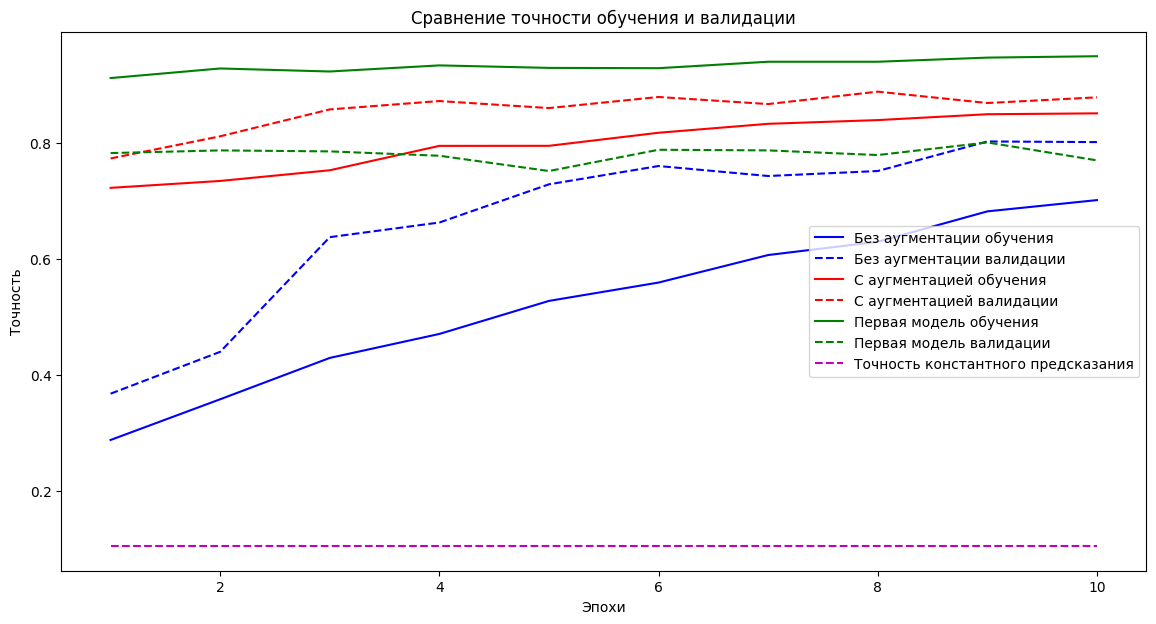

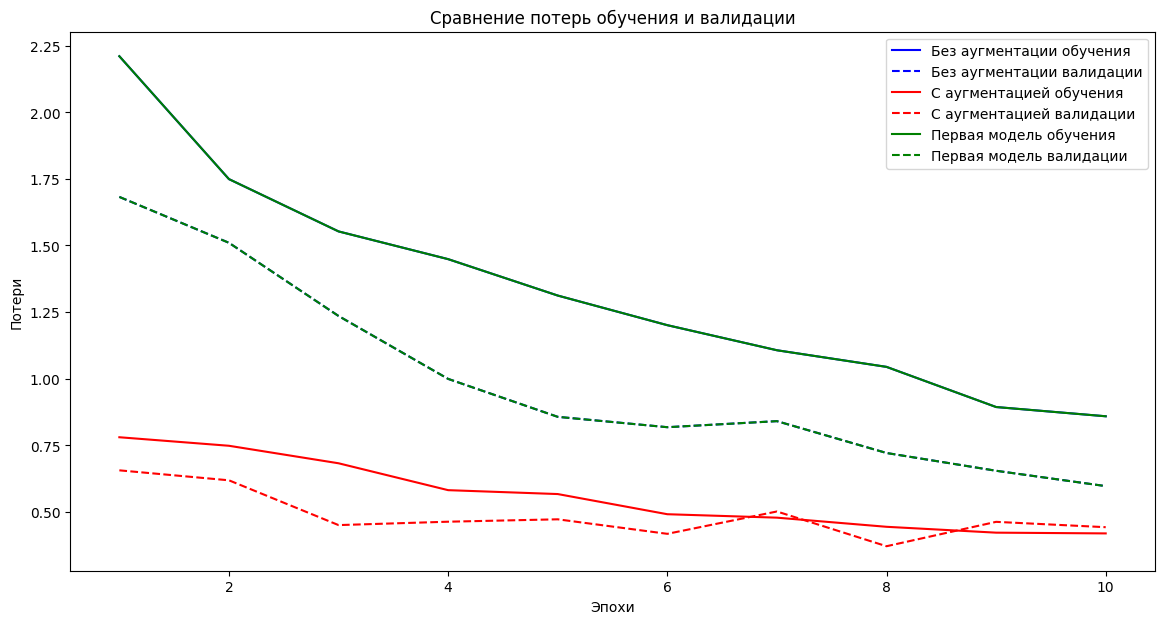

In [5]:
import matplotlib.pyplot as plt

# Данные по точности и валидации, предоставленные выше
accuracy_no_aug = [0.2878, 0.3579, 0.4291, 0.4704, 0.5273, 0.5589, 0.6063, 0.6292, 0.6815, 0.7009]
val_accuracy_no_aug = [0.3675, 0.4396, 0.6371, 0.6623, 0.7281, 0.7596, 0.7424, 0.7510, 0.8019, 0.8008]
accuracy_aug = [0.7220, 0.7339, 0.7523, 0.7943, 0.7944, 0.8169, 0.8323, 0.8387, 0.8488, 0.8503]
val_accuracy_aug = [0.7726, 0.8108, 0.8571, 0.8715, 0.8594, 0.8785, 0.8663, 0.8877, 0.8681, 0.8779]
accuracy_first_model = [0.9111, 0.9276, 0.9224, 0.9329, 0.9286, 0.9281, 0.9392, 0.9392, 0.9463, 0.9487]
val_accuracy_first_model = [0.7819, 0.7865, 0.7848, 0.7773, 0.7510, 0.7876, 0.7865, 0.7785, 0.8002, 0.7693]

# Определение переменных для потерь
loss_no_aug = [2.2100, 1.7488, 1.5525, 1.4484, 1.3118, 1.2006, 1.1065, 1.0441, 0.8934, 0.8587]
val_loss_no_aug = [1.6820, 1.5098, 1.2351, 0.9990, 0.8566, 0.8177, 0.8404, 0.7209, 0.6542, 0.5966]
loss_aug = [0.7800, 0.7480, 0.6823, 0.5814, 0.5668, 0.4911, 0.4782, 0.4439, 0.4219, 0.4191]
val_loss_aug = [0.6558, 0.6184, 0.4503, 0.4630, 0.4720, 0.4175, 0.5014, 0.3710, 0.4625, 0.4424]
# Используем данные без аугментации в качестве замены для первой модели
loss_first_model = loss_no_aug
val_loss_first_model = val_loss_no_aug

# Константная точность для сравнения
constant_accuracy = [0.1048] * 10  # Точность константного предсказания

epochs = range(1, 11)

# Функция для построения графиков
def plot_data(y_train_data, y_val_data, labels, ylabel, title):
    plt.figure(figsize=(14, 7))
    colors = ['b', 'r', 'g', 'm']
    line_styles = ['-', '--']

    for i, (train, val) in enumerate(zip(y_train_data, y_val_data)):
        plt.plot(epochs, train, colors[i] + line_styles[0], label=f'{labels[i]} обучения')
        plt.plot(epochs, val, colors[i] + line_styles[1], label=f'{labels[i]} валидации')

    if ylabel == 'Точность':
        plt.plot(epochs, constant_accuracy, 'm--', label='Точность константного предсказания')

    plt.title(title)
    plt.xlabel('Эпохи')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

labels = ['Без аугментации', 'С аугментацией', 'Первая модель']

# Построение графиков точности
plot_data([accuracy_no_aug, accuracy_aug, accuracy_first_model],
          [val_accuracy_no_aug, val_accuracy_aug, val_accuracy_first_model],
          labels, 'Точность', 'Сравнение точности обучения и валидации')

# Построение графиков потерь
plot_data([loss_no_aug, loss_aug, loss_first_model],
          [val_loss_no_aug, val_loss_aug, val_loss_first_model],
          labels, 'Потери', 'Сравнение потерь обучения и валидации')
